# [SITCOMTN-XXX] - M1M3 - analyze position and rotation stability throughout a tracking period

2023-12-14 Laura

This notebook evaluates displacements of M1M3 for X, Y, Z, RX, RY, and RZ during the period beteween slews while tracking (approximately 30 s) and check if they comply with the 2 micron and 2e-5 degree requirement.


In [64]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from astropy.time import Time, TimezoneInfo
from statsmodels.tsa.stattools import adfuller

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient

from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')

from scipy import stats 

In [66]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

### Define relevant settings

#### Requirements

In [67]:
req_rms_position = 2e-3 ## mm, tolerance from repeatability requirement for IMS positional
req_rms_rotation = 2e-5 ## degrees, tolerance from repeatability requirement for IMS rotational

### Define functions

In [149]:
def computeSettleTrack(
    df_ims,  # input data frame
    tt_start="2023-06-01T06:00:0Z",  # time for slew start
    tt_end = "2023-06-01T06:00:0Z",  # time for track stop
    imsColumn="xPosition",  # IMS column
    rmsReq=2e-3,  # requirement in appropriate units
    #req_delta_t=3,  # time for settling, in seconds
    chi2prob=0.999,  # confidence level for IMS variable wrt to long term value and variance to agree
    delta_t=5
):
    if "Position" in imsColumn:
        units = "mm"
        ylimMax = rmsReq + 0.005
    elif "Rotation" in imsColumn:
        units = "deg"
        ylimMax = rmsReq + 0.00005
    else:
        print("Unidentified column")
        return -1
 
    # Define Times
    T0 = pd.to_datetime(tt_start) - pd.to_timedelta(delta_t, unit="s")
    T1 = pd.to_datetime(tt_end) + pd.to_timedelta(delta_t, unit="s")
    t_track_starts = pd.to_datetime(tt_start)
    t_track_ends = pd.to_datetime(tt_end)
    # We removed 0.1s from the tracking check to eliminate the moment when the telescope starts moving.
    t_track_starts_check = pd.to_datetime(tt_start) + pd.to_timedelta(0.1, unit="s")
    t_track_ends_check = pd.to_datetime(tt_end) - pd.to_timedelta(0.1, unit="s")


    # Define Target
    # targetVariablePlot takes the data frame for the complete plot range
    targetVariablePlot = df_ims[imsColumn][T0 : T1]
    
    # Define index
    idxT0 = df_ims.index[  # index in dataframe closest in time to start of plot
        df_ims.index.get_indexer([pd.to_datetime(T0)], method="nearest")
    ]
    idxT1 = df_ims.index[  # index in dataframe closest in time to end of plot
            df_ims.index.get_indexer([pd.to_datetime(T1)], method="nearest")
    ] 

    targetVariableReference = [
        float(df_ims[imsColumn][idxT0]),
        float(df_ims[imsColumn][idxT1]),
    ]
    if len(targetVariablePlot.index) == 0:
        print("Data frame is empty")
        return -1
    
    correctedVariablePlot = targetVariablePlot - targetVariableReference[1]

    # Tracking time
    tracking_time = t_track_ends - t_track_starts
    total_seconds = tracking_time.total_seconds()
    seconds = total_seconds % 60
    seconds_decimal = "{:.2f}".format(seconds)  # 

    if seconds < 2:
        print("Warning: tranking duration less than 2 seconds")
        return -1
        
    # Check stability
    filtered_correctedVariablePlot = correctedVariablePlot.loc[t_track_starts_check:t_track_ends_check]
    if any(abs(filtered_correctedVariablePlot) > rmsReq):
        print("Warning! Telescope movement during tracking exceeds the required rms limits in", imsColumn)

    
        # Plot
        title = f"Tracking time: {seconds_decimal} seconds"
        fig = plt.figure()
        label = "Corrected " + imsColumn + "(" + units + ") difference wrt end of plot"
        plt.title(title)    
    
        plt.plot(
            correctedVariablePlot,
            color="red",
            ls="dashed",
            lw="0.5",
            label=label,
        )

        plt.axhline(-rmsReq, lw="0.75", c="k", ls="dashed", label="IMS repeatability req.")
        plt.axhline(rmsReq, lw="0.75", c="k", ls="dashed")
        plt.axvline(x=t_track_starts, color='black', linestyle='dashed', linewidth=1.2, label='Start of Tracking')
        plt.axvline(x=t_track_ends, color='black', linestyle='dashed', linewidth=1.2, label='End of Tracking')

        plt.xlabel("Time [UTC]")
        plt.ylabel(f"{imsColumn} {units}")
        plt.ylim(-ylimMax, ylimMax)
        fig.autofmt_xdate()
        plt.legend(loc="upper right", fontsize="8")
        fig.tight_layout()



In [69]:
def compareIMSMount(
    df_ims,
    df_mtmount_ele,
    df_mtmount_azi,
    referenceTime="2023-06-01 06:53:37.326",
    end_t="2023-06-01 06:53:37.326",
    delta_t=5
):
    fig, axs = plt.subplots(5, 1, dpi=125, figsize=(6, 8))
    t_start_plot = pd.to_datetime(referenceTime) - pd.to_timedelta(delta_t, unit="s")
    t_end_plot = pd.to_datetime(end_t) + pd.to_timedelta(delta_t, unit="s")

    ax = axs[0]
    actpos_ele = df_mtmount_ele["actualPosition"][t_start_plot:t_end_plot]
    ax.plot(actpos_ele, color="red", lw=0.5)  
    ax.axvline(pd.to_datetime(referenceTime), lw=1, c="k", ls="--") 
    ax.axvline(pd.to_datetime(end_t), lw=1, c="k", ls="--")  
    ax.set_ylabel("Elevation\nPosition\n[deg]")
    ax.text(
        pd.to_datetime(referenceTime)+ pd.to_timedelta((t_start_plot - referenceTime) / 2),
        max(actpos_ele) + 0.01* max(actpos_ele),
        "Slew",
        horizontalalignment="center",
        fontsize=8,
    )
    ax.text(
        pd.to_datetime(end_t) - pd.to_timedelta((end_t - t_end_plot) / 2),
        max(actpos_ele) + 0.01* max(actpos_ele),
        "Slew",
        horizontalalignment="center",
        fontsize=8,
    )
    ax.text(
        pd.to_datetime(referenceTime) + pd.to_timedelta((end_t - referenceTime) / 2),
        max(actpos_ele) + 0.01* max(actpos_ele),
        "Tracking",
        horizontalalignment="center",
        fontsize=8,
    )
      
    ax = axs[1]
    actpos_azi = df_mtmount_azi["actualPosition"][t_start_plot:t_end_plot]
    ax.plot(actpos_azi, color="red", lw=0.5)
    ax.axvline(pd.to_datetime(referenceTime), lw=1, c="k", ls="--", label="Starts Tracking") 
    ax.axvline(pd.to_datetime(end_t), lw=1, c="k", ls="--", label="End Tracking")
    ax.set_ylabel("Azimuth\nPosition\n[deg]")

    plotstring = ["xPosition", "yPosition", "zPosition"]
    plotrange = np.arange(len(plotstring))
    for i in plotrange:
        ax = axs[i + 2]
        pos = df_ims[plotstring[i]][t_start_plot:t_end_plot]
        ax.plot(pos, color="red", lw="0.5")
        ax.axvline(pd.to_datetime(referenceTime), lw=1, c="k", ls="--")
        ax.axvline(pd.to_datetime(end_t), lw=1, c="k", ls="--")
        ax.set_ylabel(plotstring[i] + " \n[mm]")
    ax.set_xlabel("UTC")
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=1)
    fig.suptitle(referenceTime)
    fig.legend()
    fig.tight_layout()

### Definition of case

#### Observation day

In [91]:
dayObs = 20231129  #20231129

In [92]:
## Define column names
all_columns = [
    "xPosition",
    "yPosition",
    "zPosition",
    "xRotation",
    "yRotation",
    "zRotation",
]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

In [93]:
delta_t = 5

#### Get slew stops

In [94]:
# Select data from a given date
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type==TMAState.SLEWING]
tracks = [e for e in events if e.type==TMAState.TRACKING]
print(f'Found {len(slews)} slews and {len(tracks)} tracks')

Found 492 slews and 378 tracks


In [95]:
# Get events related to soak tests (block 137 currently)
block137Events = []
for event in events:
    blockInfos = event.blockInfos
    if blockInfos is None:
        continue  # no block info attached to event at all

    # check if any of the attached blockInfos are for block 137
    blockNums = {b.blockNumber for b in blockInfos}
    if 137 in blockNums:
        block137Events.append(event)

print(f"Of the {len(events)} events, {len(block137Events)} relate to block 137.")

Of the 870 events, 750 relate to block 137.


In [96]:
# Print out sequential number of events that have certain characteristics
t = 0
tracks_block137 = []
for i in range(len(block137Events)):
    if (
        block137Events[i].endReason == TMAState.SLEWING
        and block137Events[i].type == TMAState.TRACKING
    ):
        t = t + 1
        print(block137Events[i].seqNum, end=", ")
        tracks_block137.append(block137Events[i])

12, 14, 16, 18, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 119, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 195, 197, 199, 201, 203, 205, 207, 209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233, 235, 237, 239, 241, 243, 245, 247, 249, 251, 253, 255, 257, 259, 261, 263, 265, 267, 269, 271, 273, 275, 277, 279, 281, 283, 285, 287, 289, 291, 293, 295, 297, 299, 301, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 331, 333, 335, 337, 339, 341, 343, 345, 347, 349, 351, 353, 355, 357, 364, 371, 373, 375, 378, 386, 396, 398, 400, 402, 404, 406, 408, 410, 412, 414, 416, 418, 420, 422, 424, 426, 428, 430, 432, 434, 436, 438, 440, 442, 444, 447, 449, 451, 453, 455, 457, 459, 461, 463, 465, 467, 469, 471, 473, 475, 477, 479, 481, 483, 485, 487, 489, 491, 493, 495, 497, 499, 501, 503, 505, 507, 509, 511, 513, 515, 517, 519, 521, 523, 52

In [15]:
# Number of TRACKING in block 137
print(f"Of the {len(block137Events)} events of block 137, {t} are trackings.")

Of the 750 events of block 137, 370 are trackings.


tracking number:  0
tracking number:  1
Warning! Telescope movement during tracking exceeds the required rms limits in zRotation
tracking number:  2
Warning! Telescope movement during tracking exceeds the required rms limits in zRotation
tracking number:  3
tracking number:  4
tracking number:  5
Warning! Telescope movement during tracking exceeds the required rms limits in zRotation
tracking number:  6
Warning! Telescope movement during tracking exceeds the required rms limits in zRotation
tracking number:  7
tracking number:  8
tracking number:  9
tracking number:  10
tracking number:  11
tracking number:  12
tracking number:  13
Warning! Telescope movement during tracking exceeds the required rms limits in zRotation
tracking number:  14
tracking number:  15
Warning! Telescope movement during tracking exceeds the required rms limits in zRotation
tracking number:  16
Warning! Telescope movement during tracking exceeds the required rms limits in zRotation
tracking number:  17
tracking 

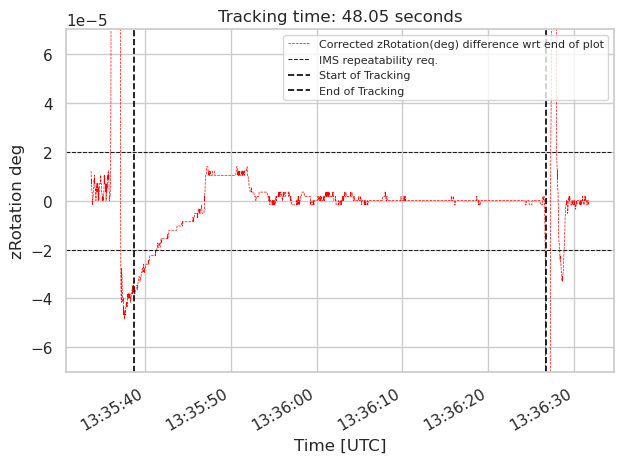

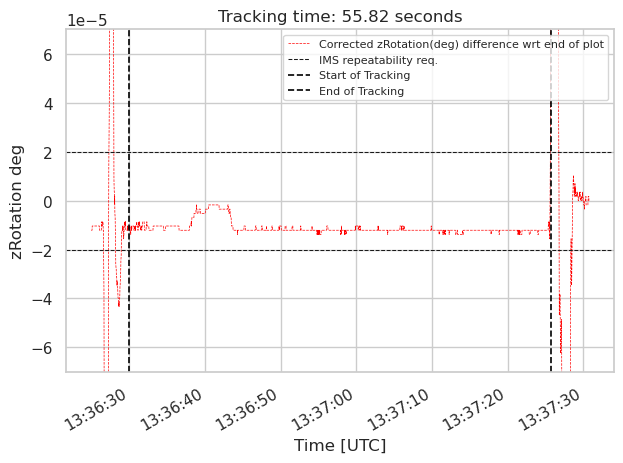

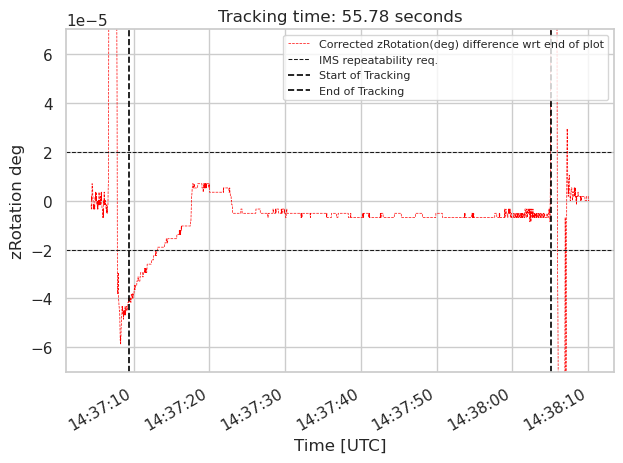

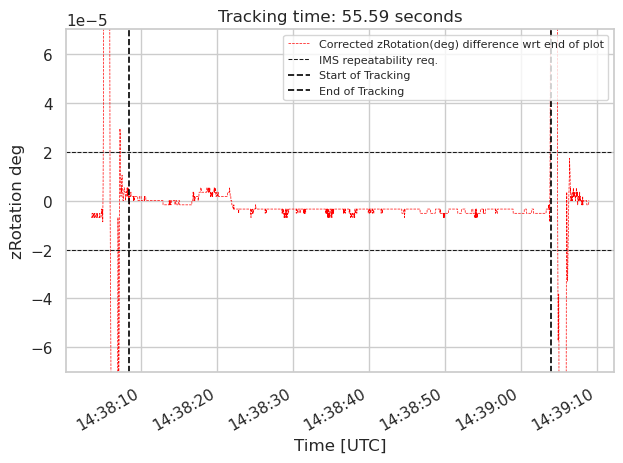

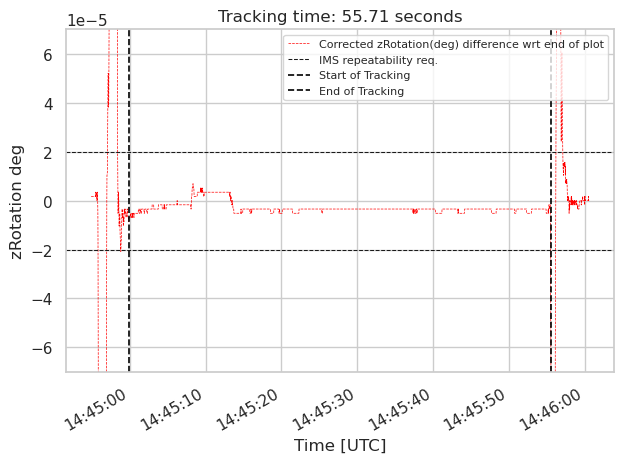

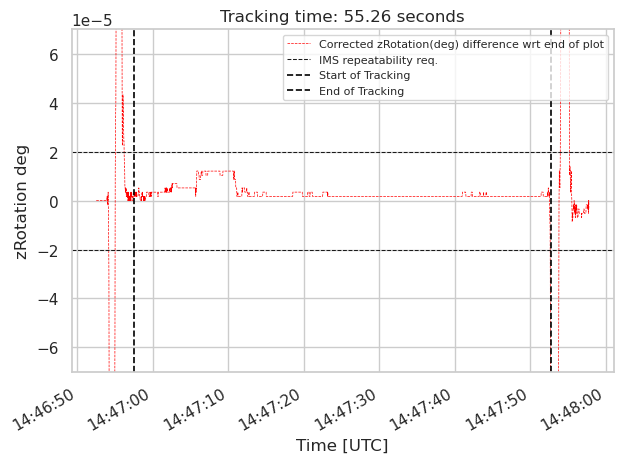

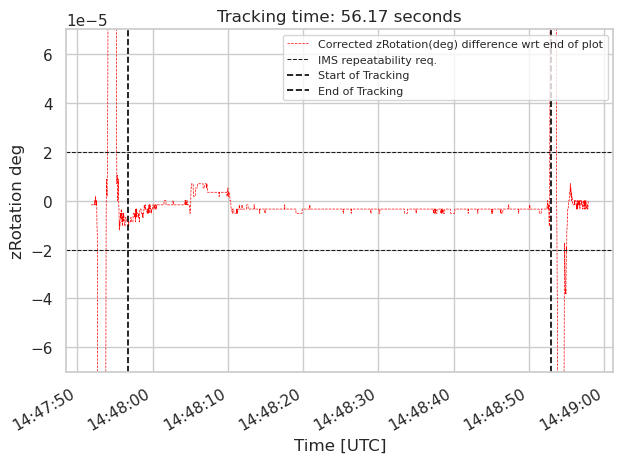

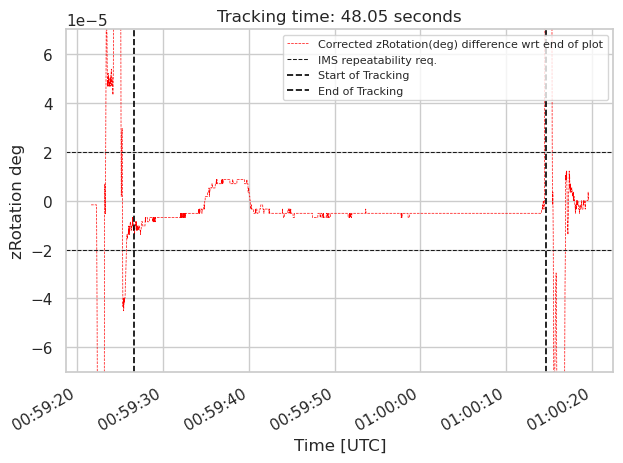

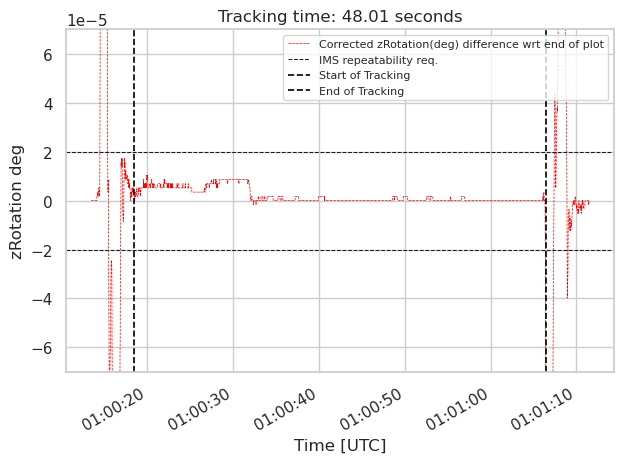

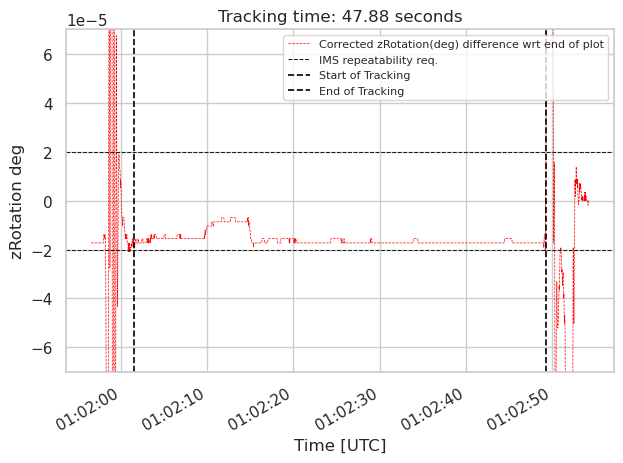

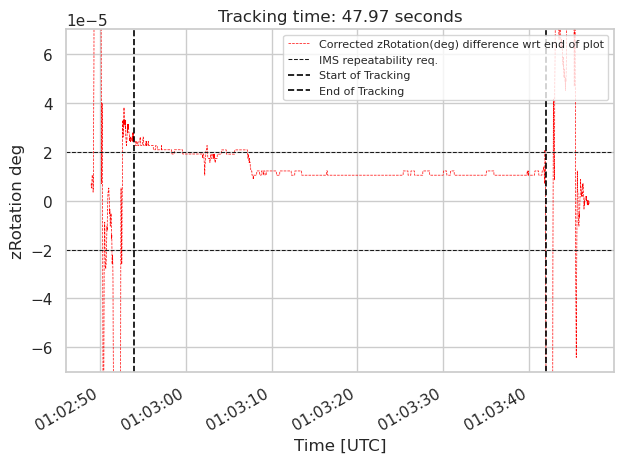

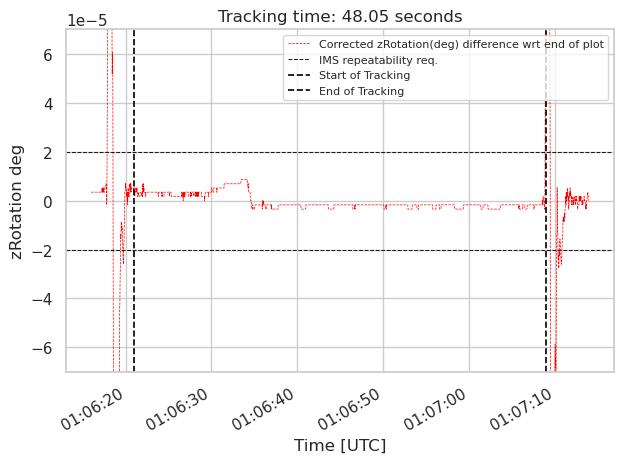

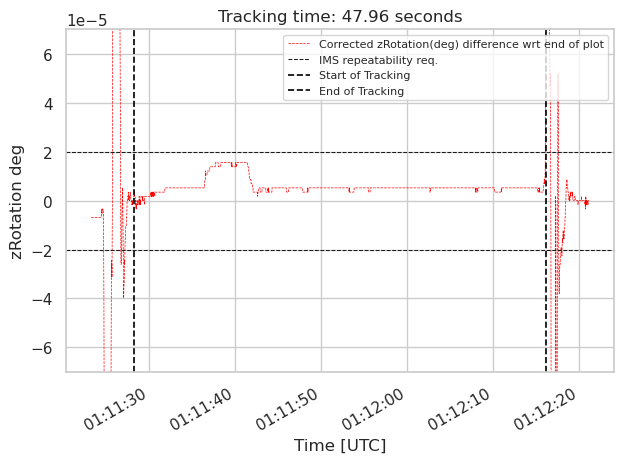

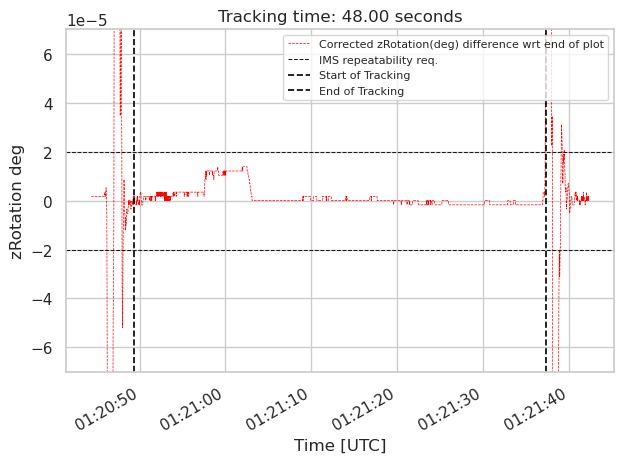

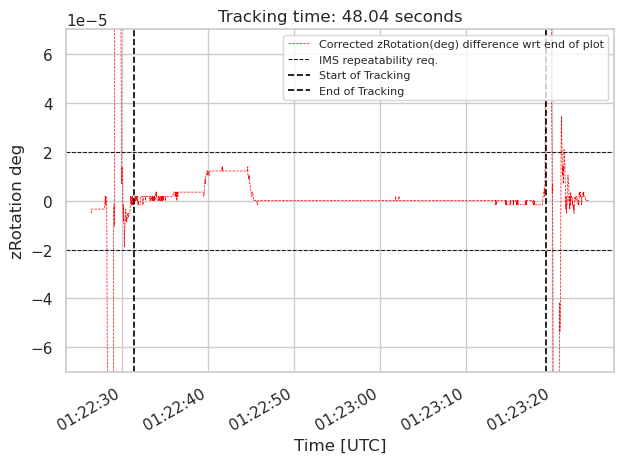

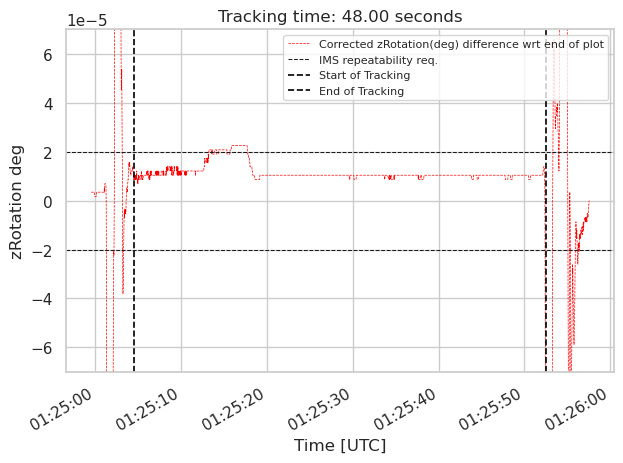

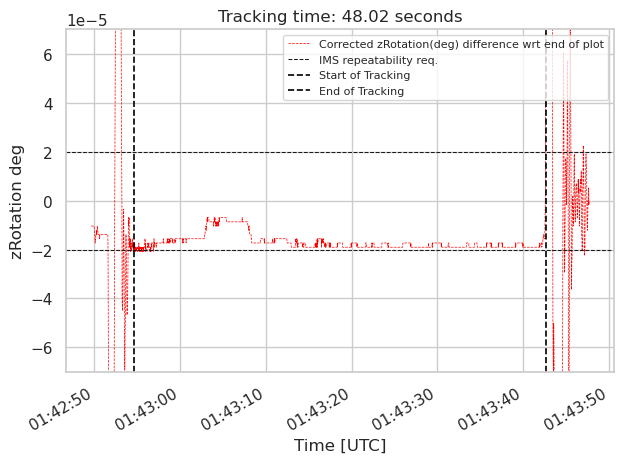

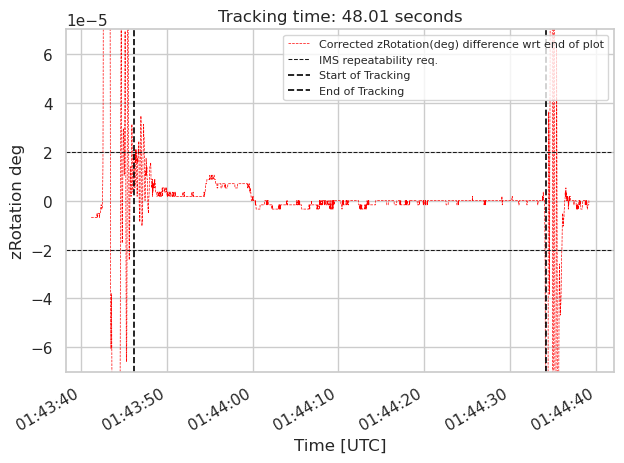

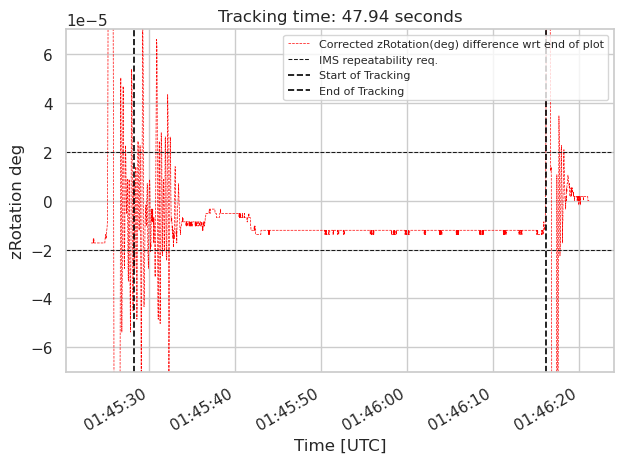

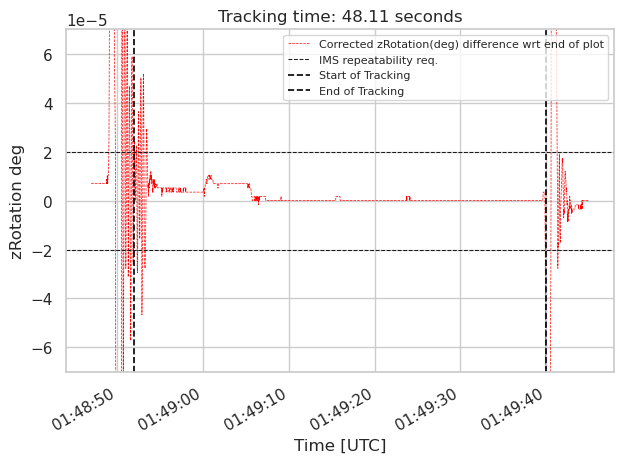

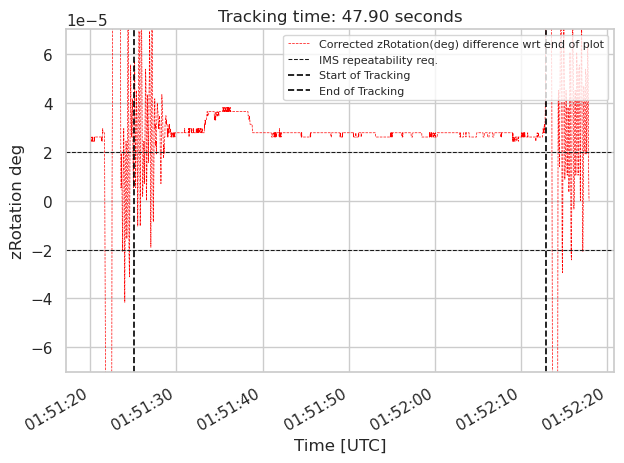

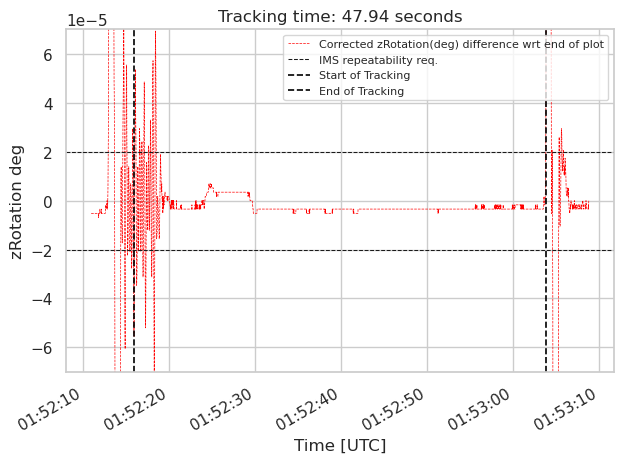

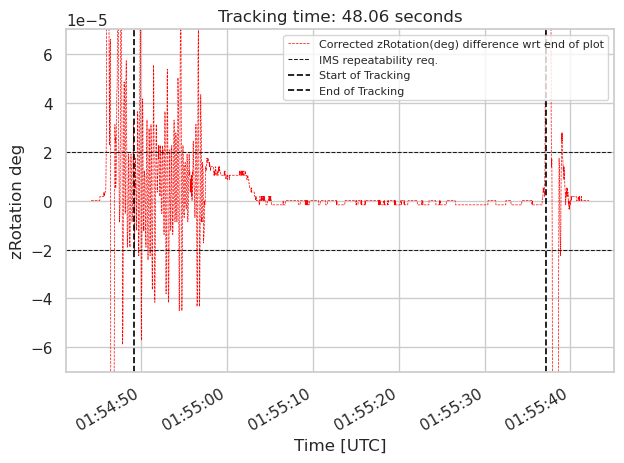

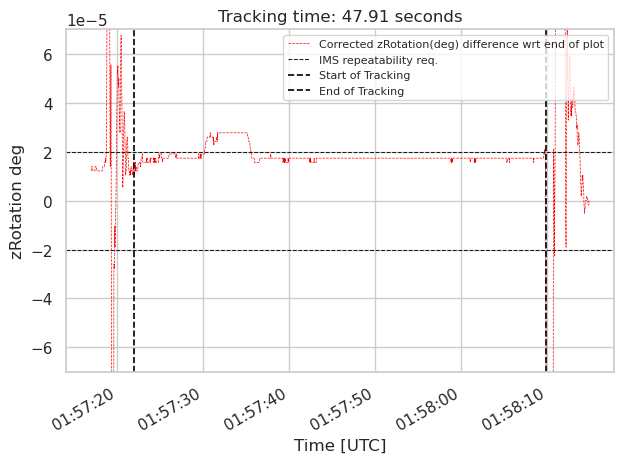

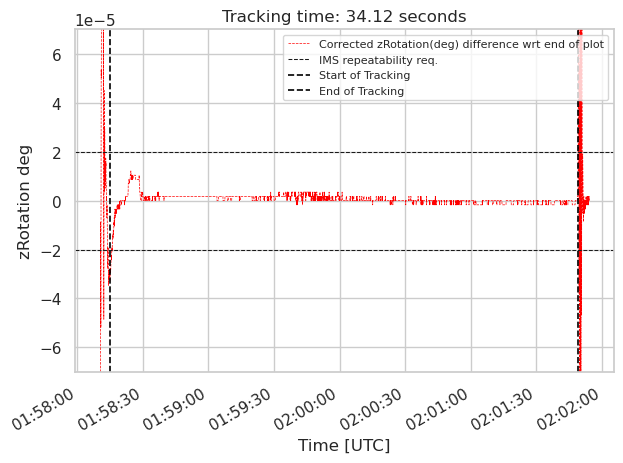

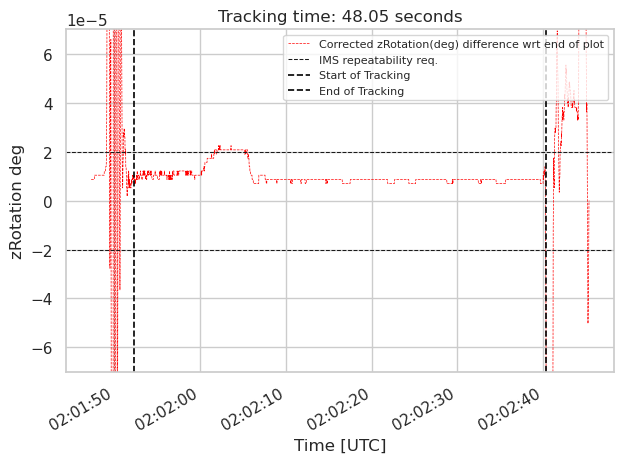

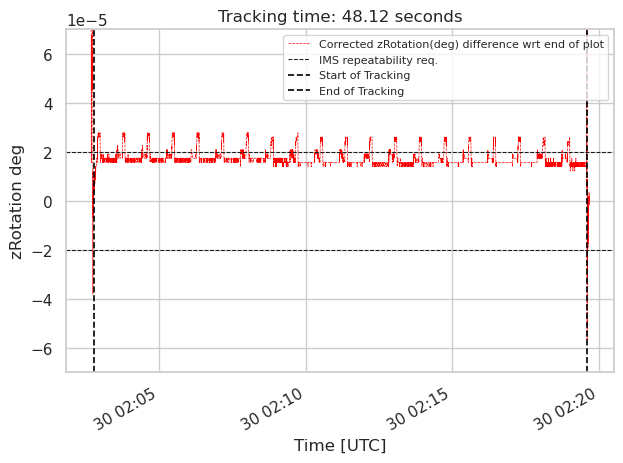

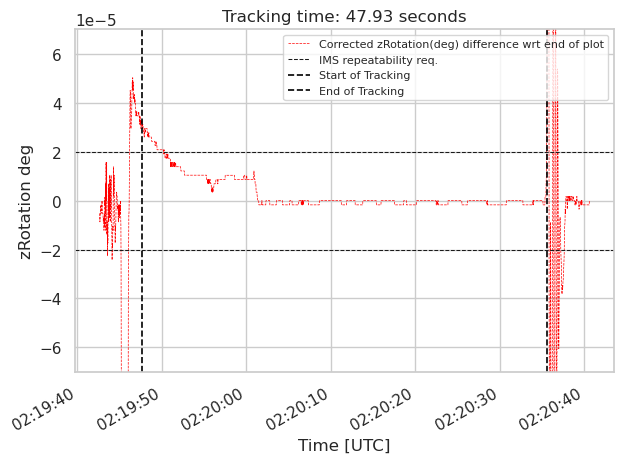

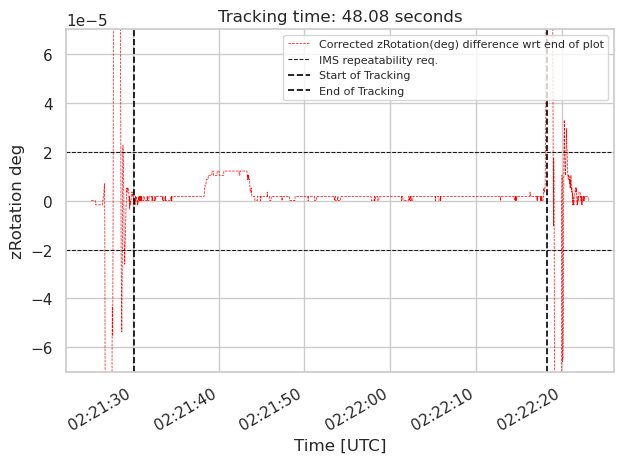

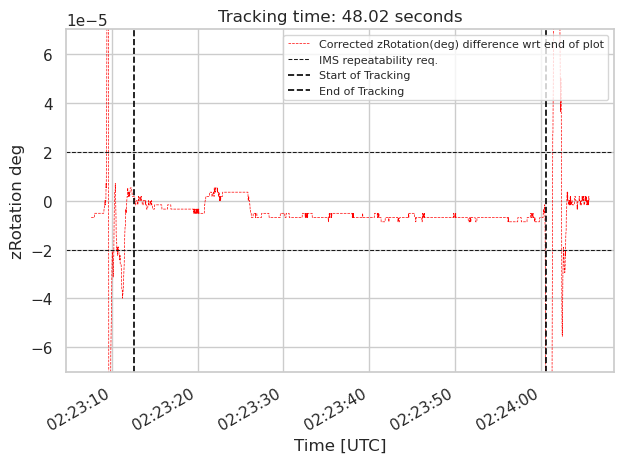

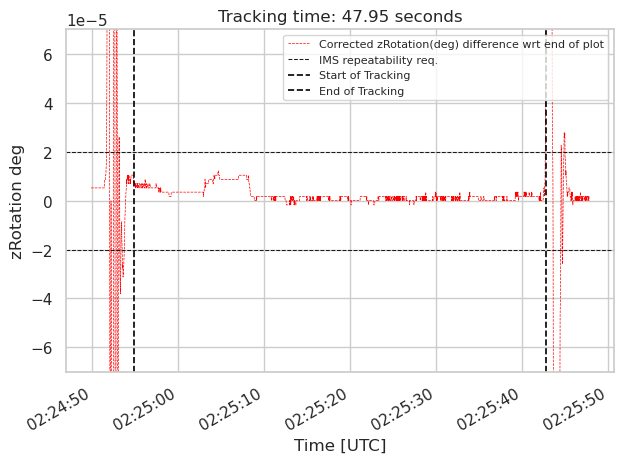

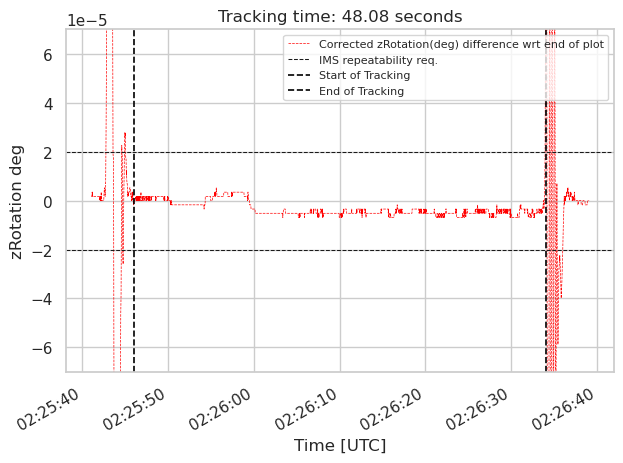

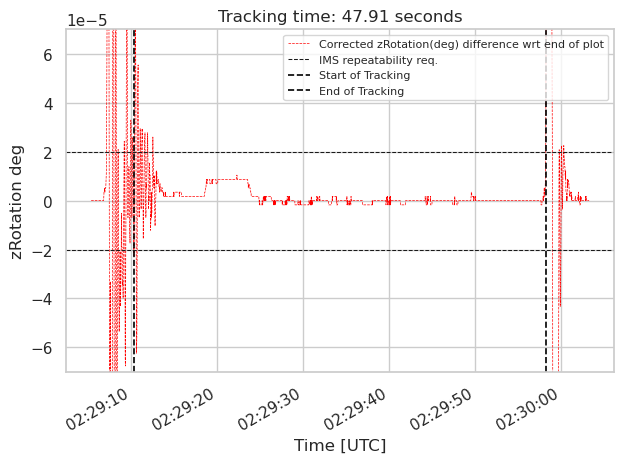

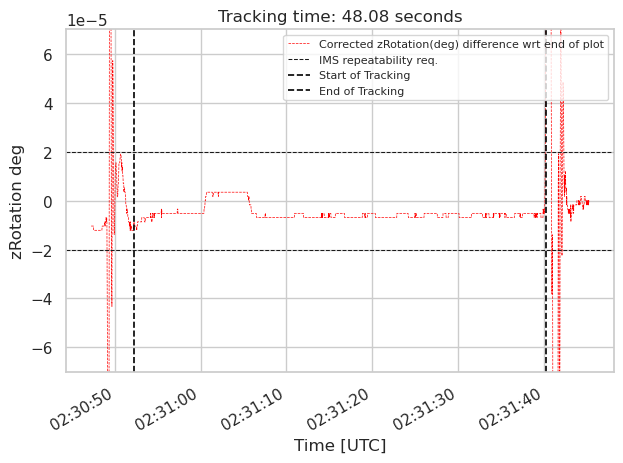

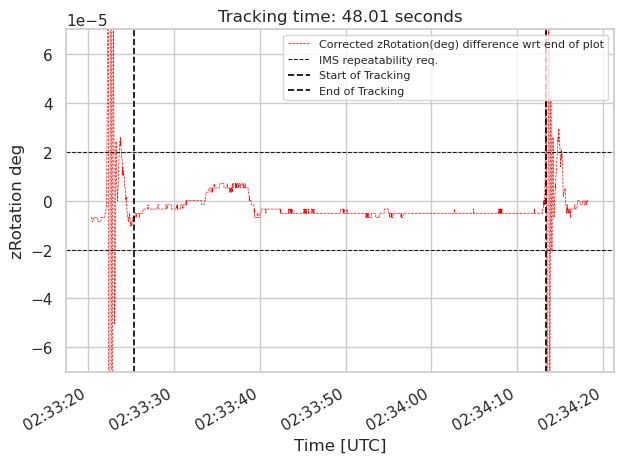

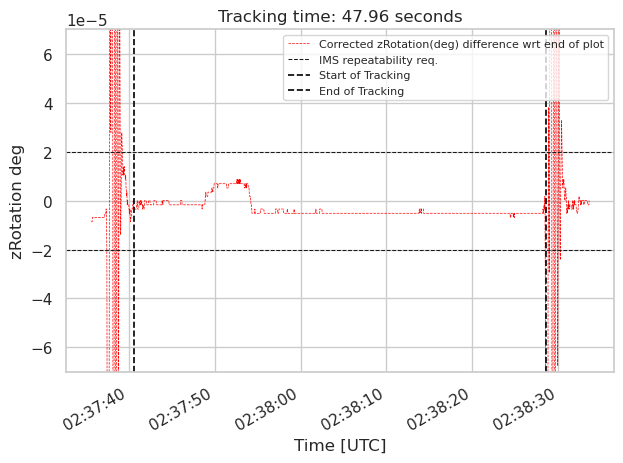

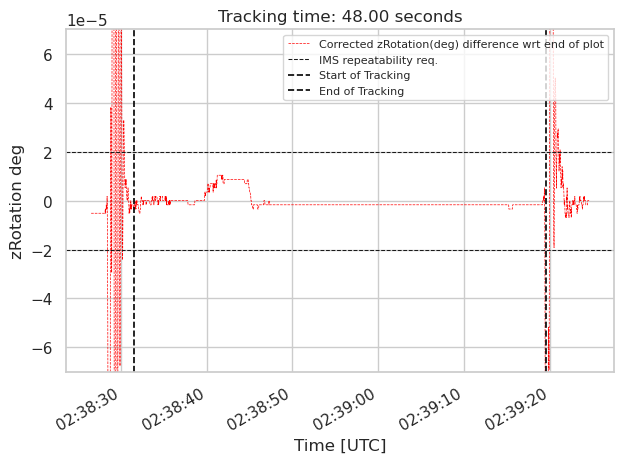

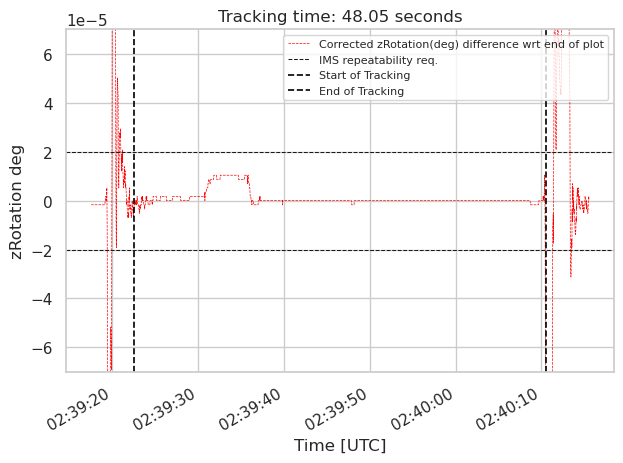

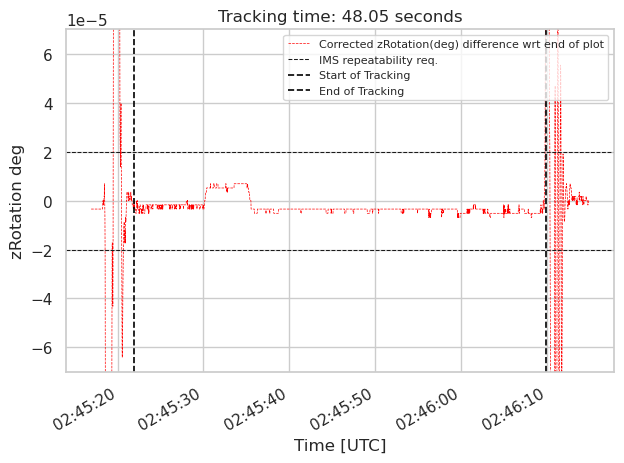

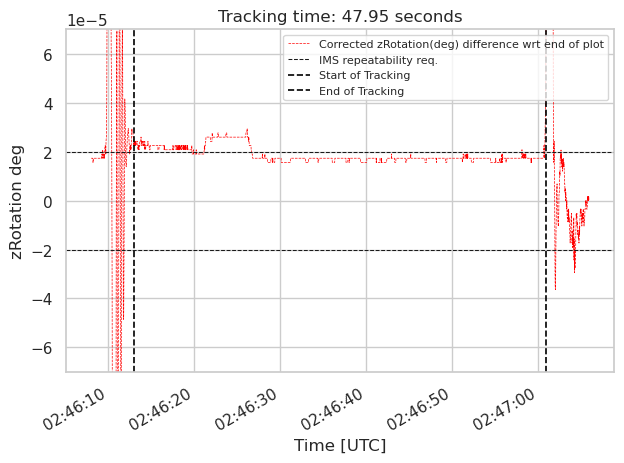

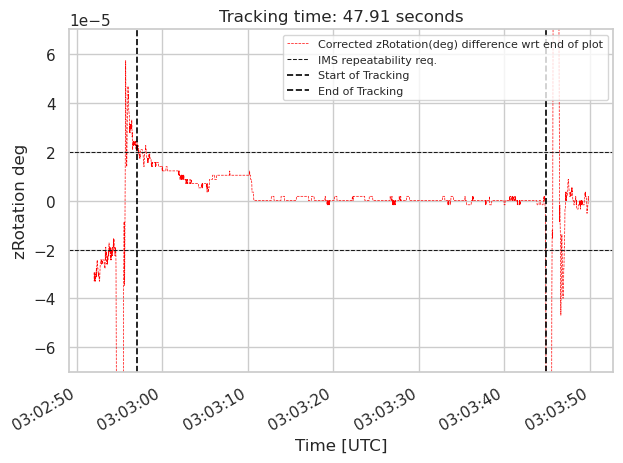

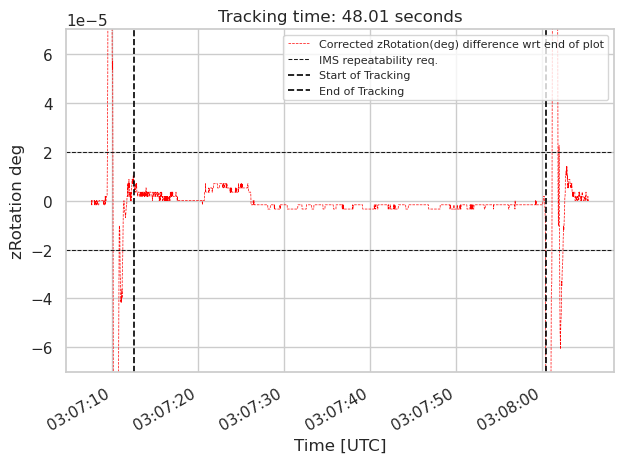

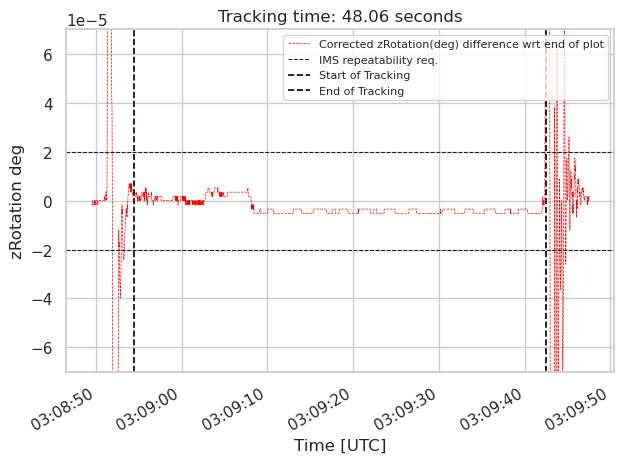

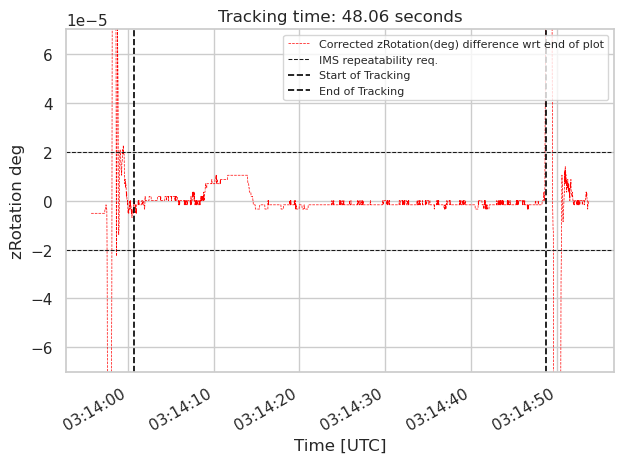

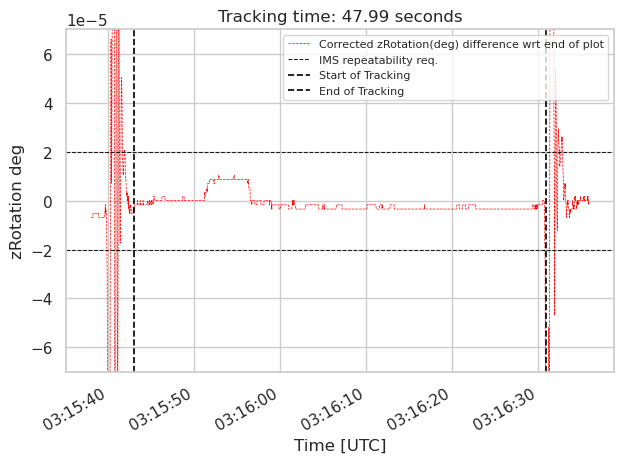

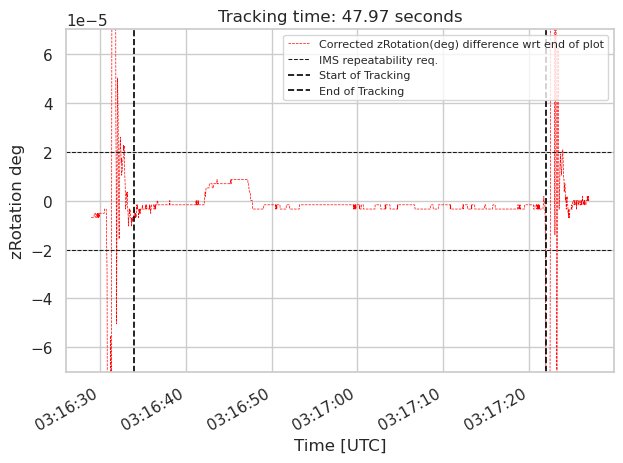

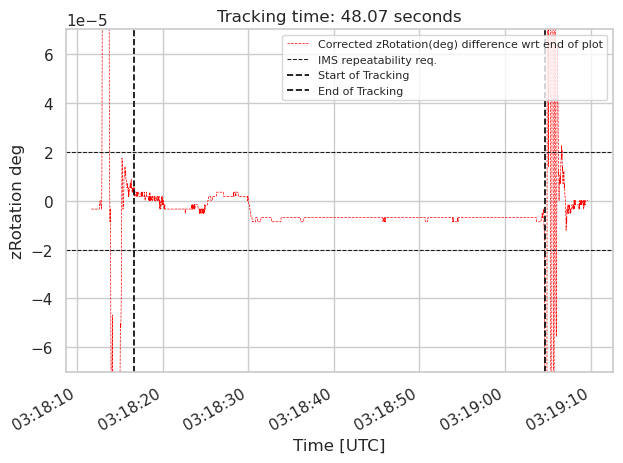

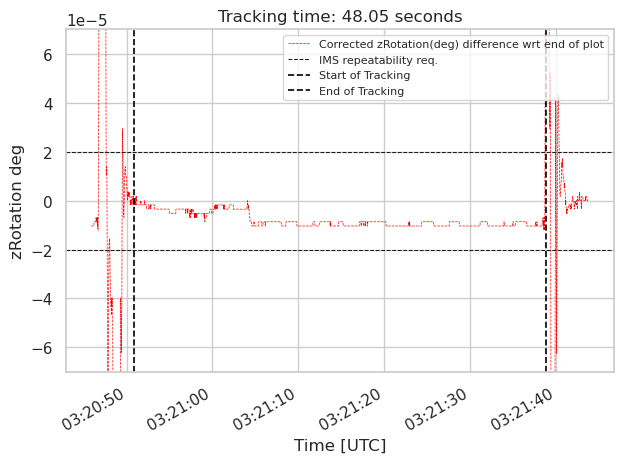

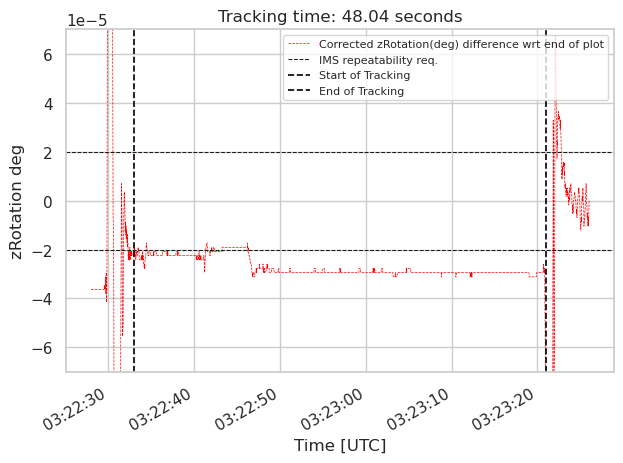

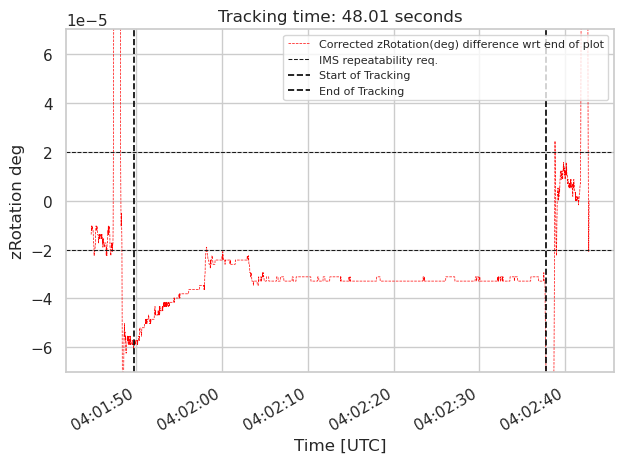

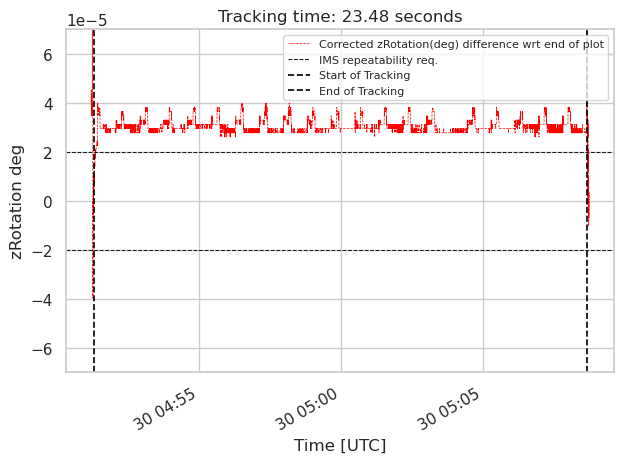

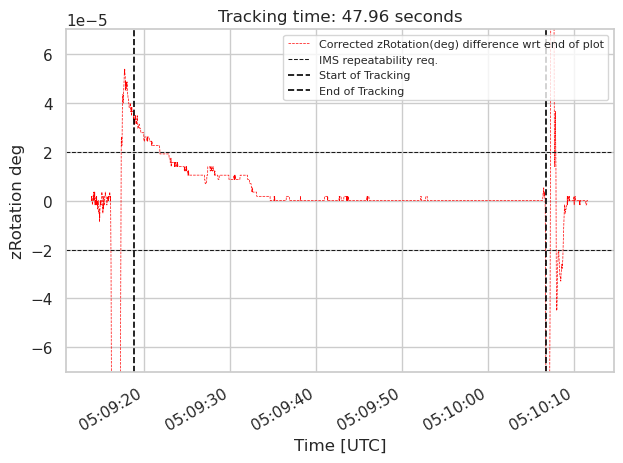

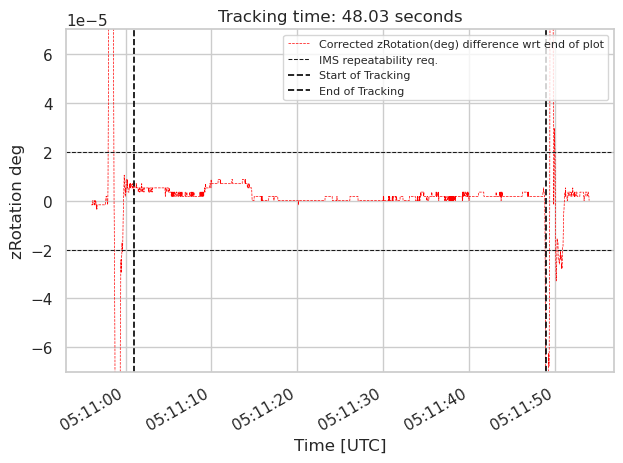

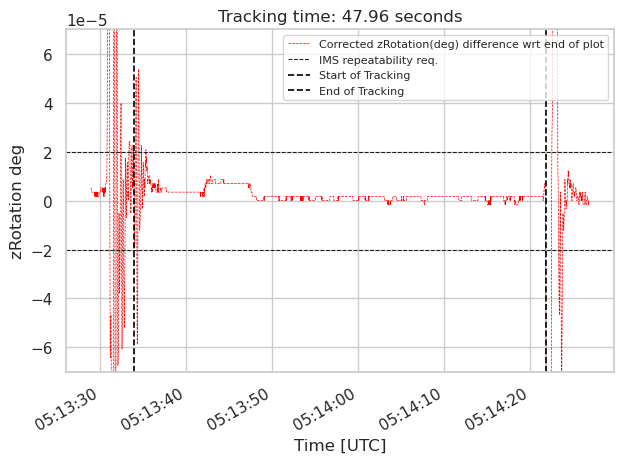

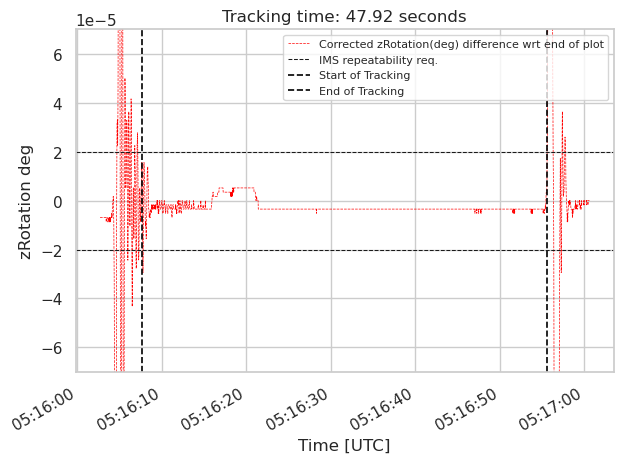

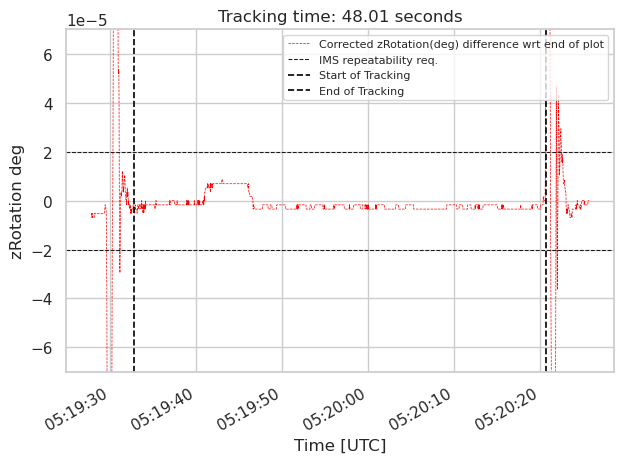

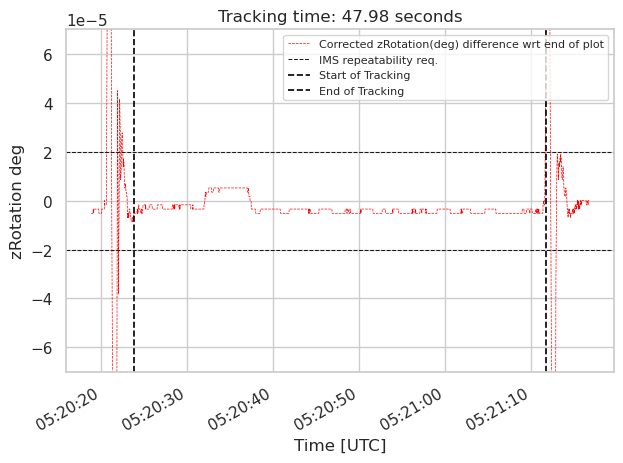

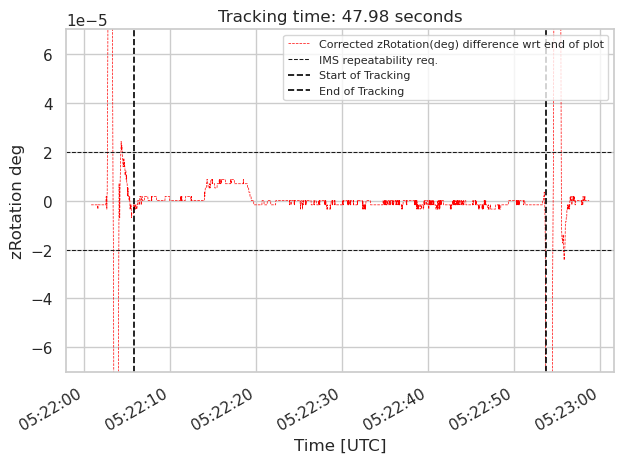

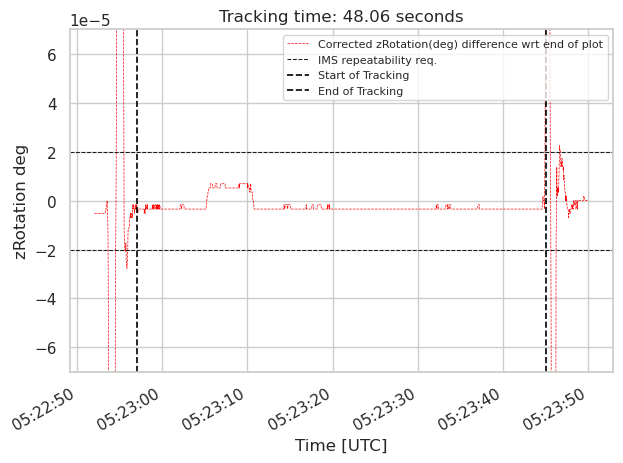

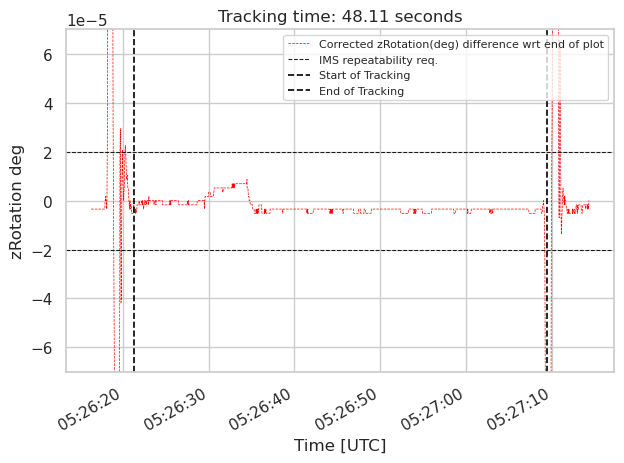

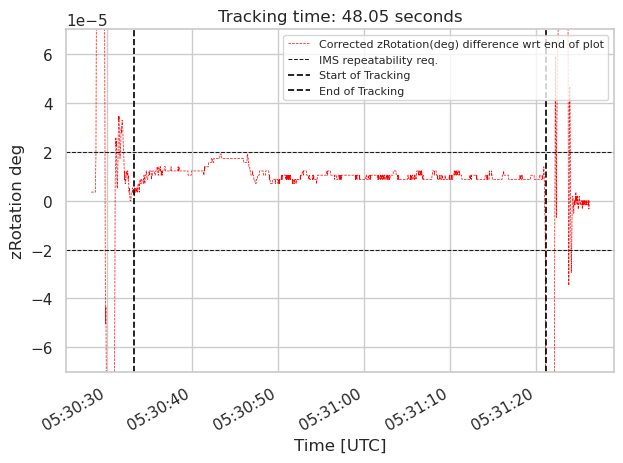

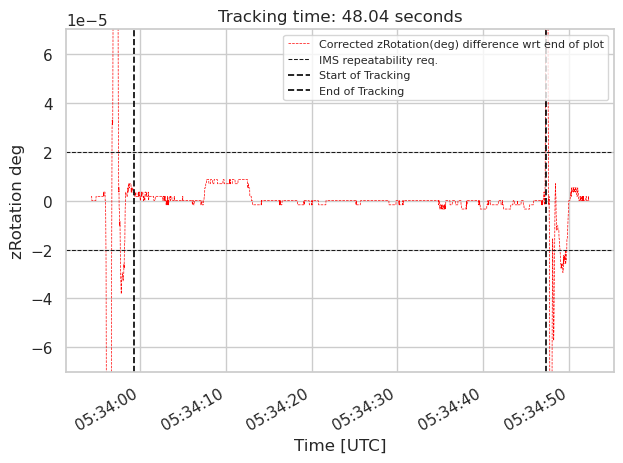

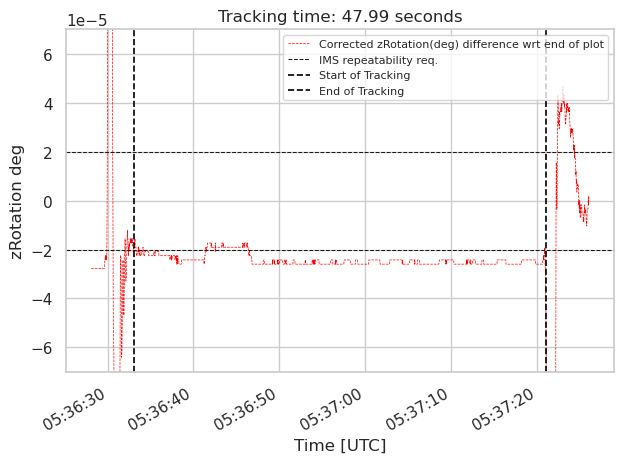

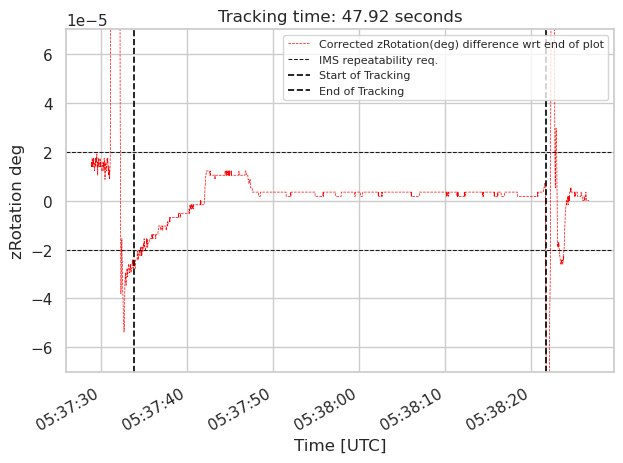

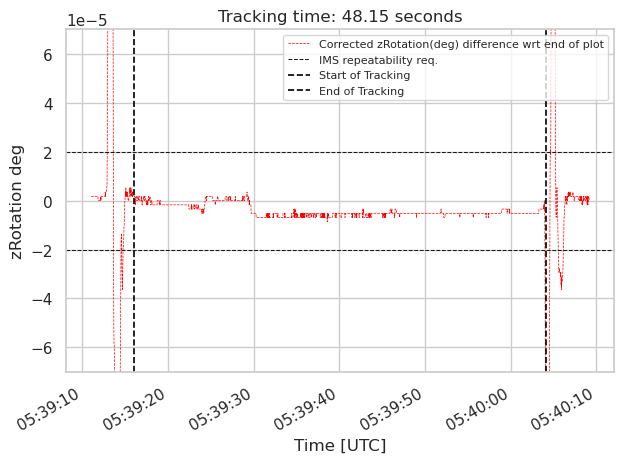

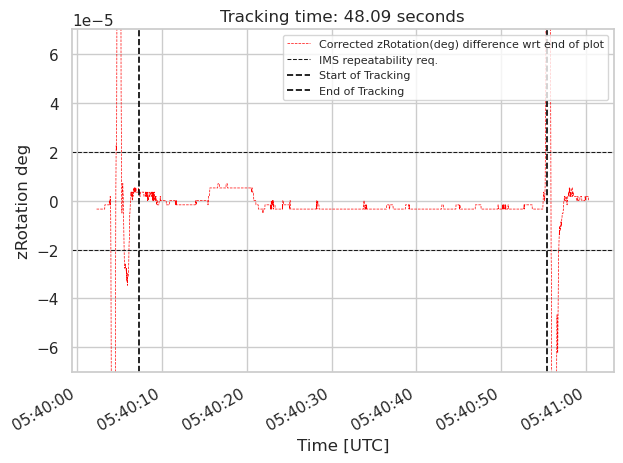

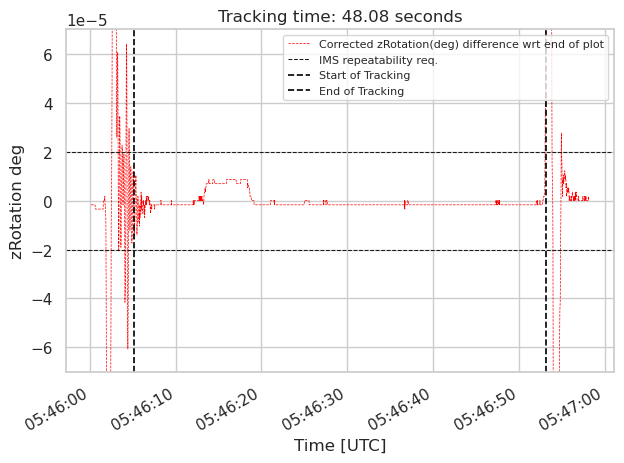

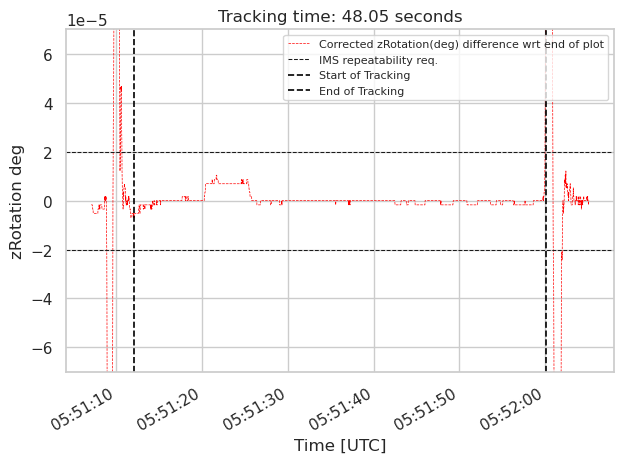

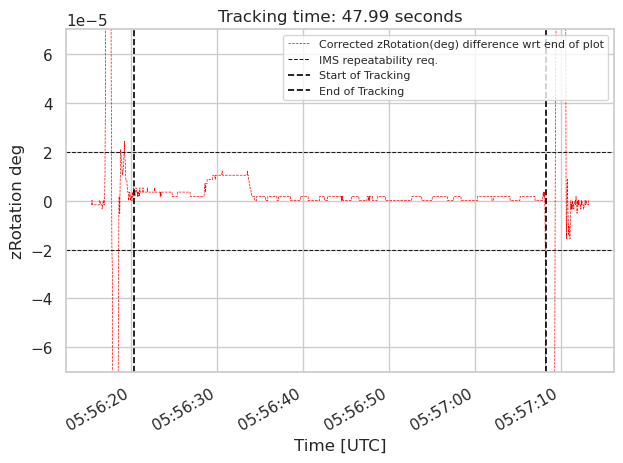

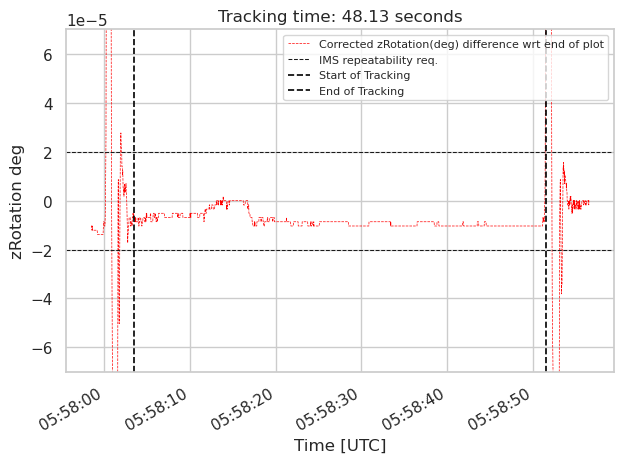

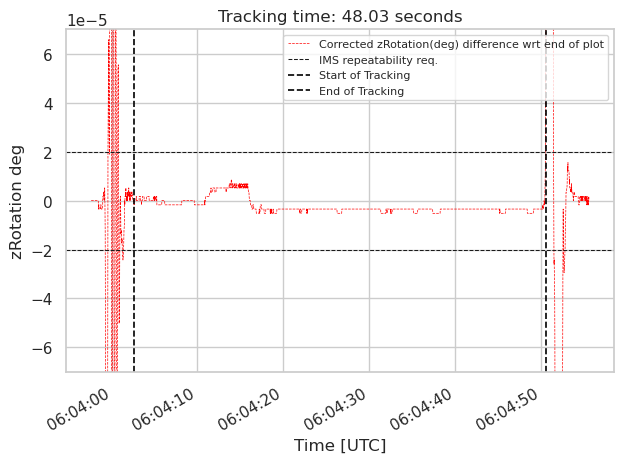

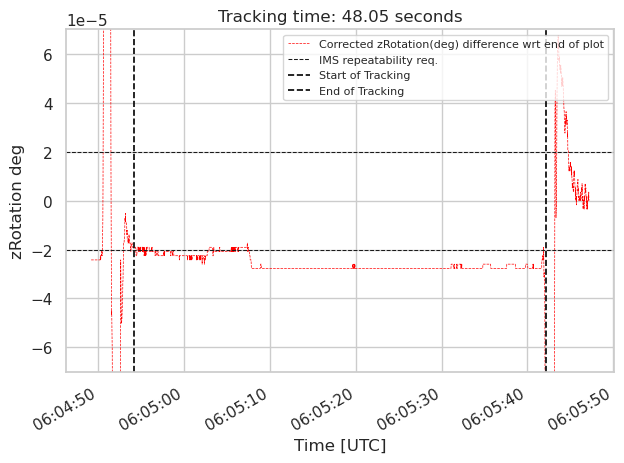

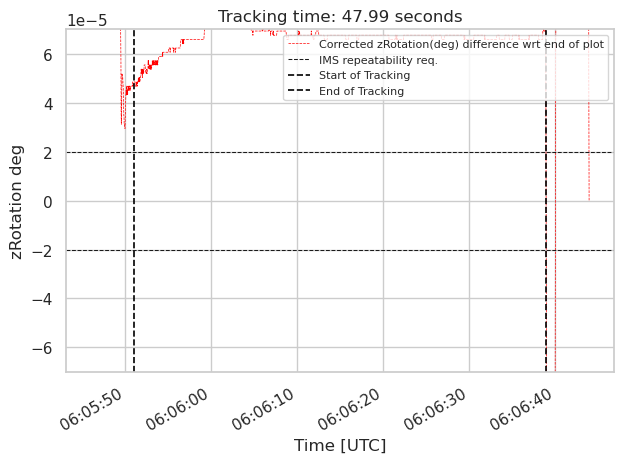

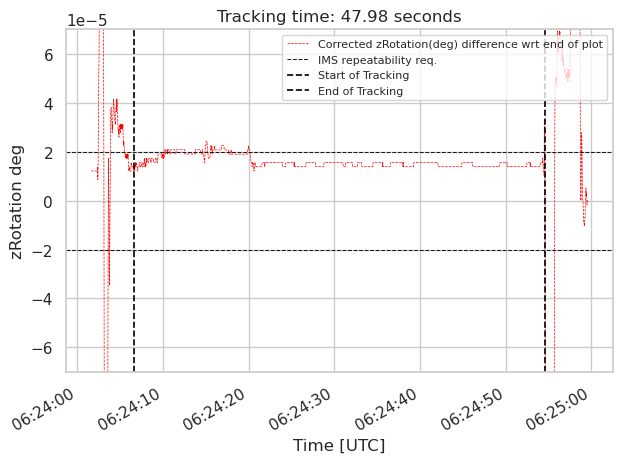

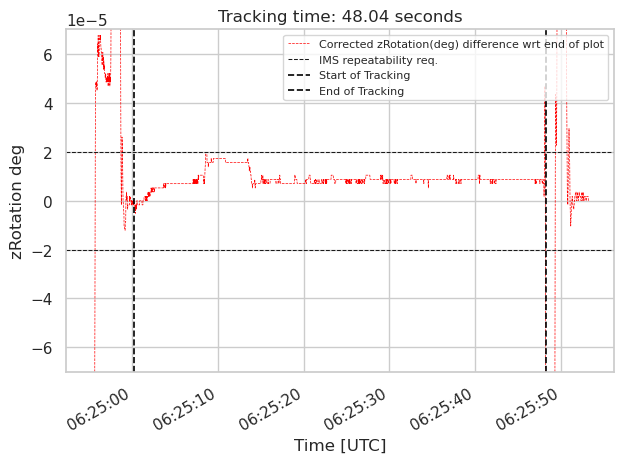

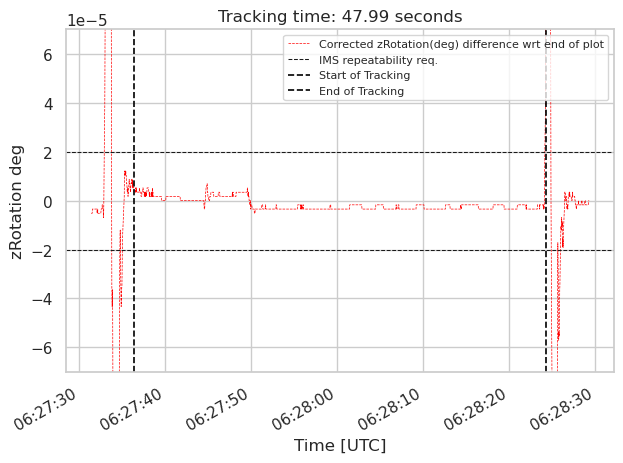

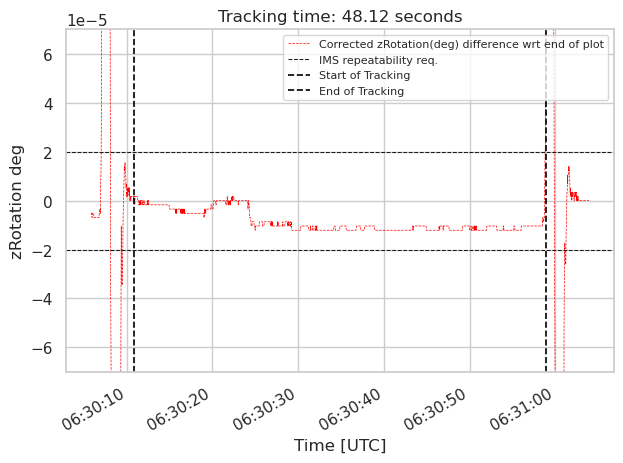

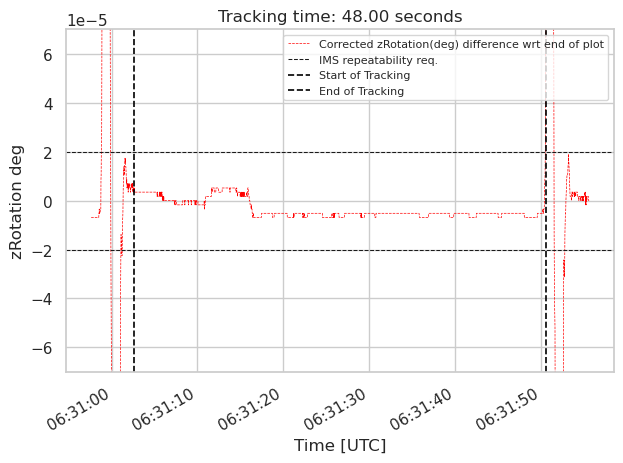

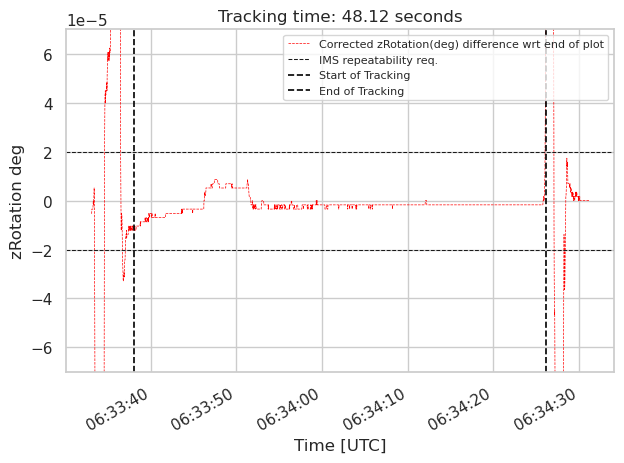

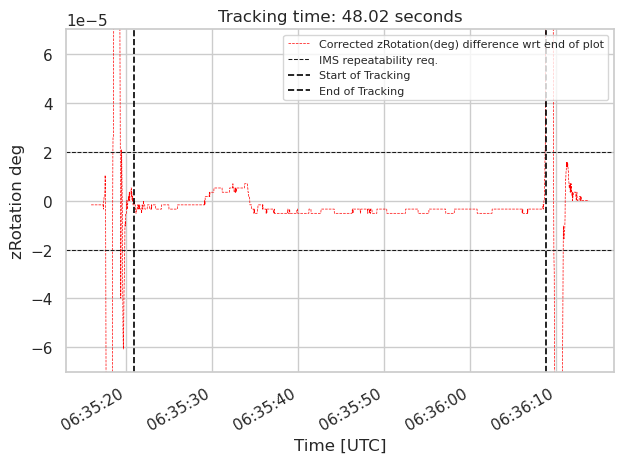

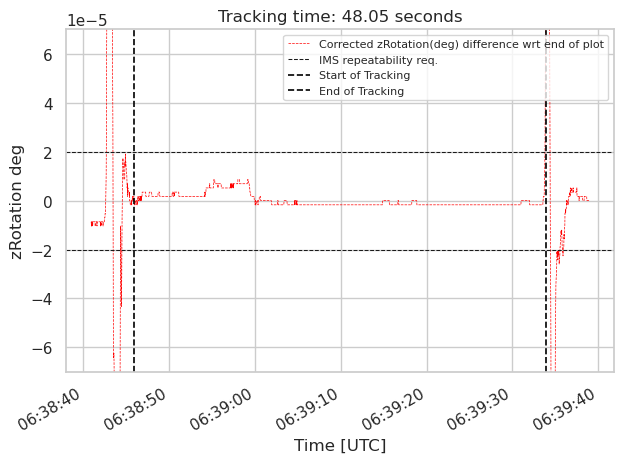

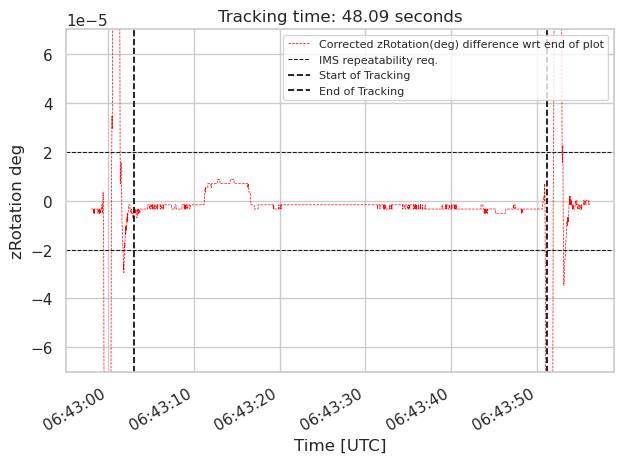

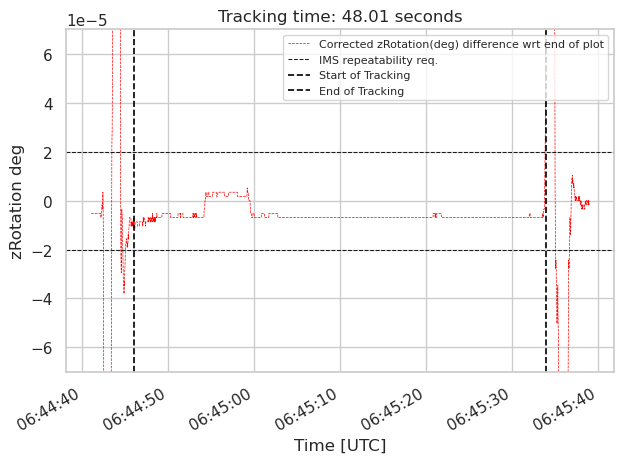

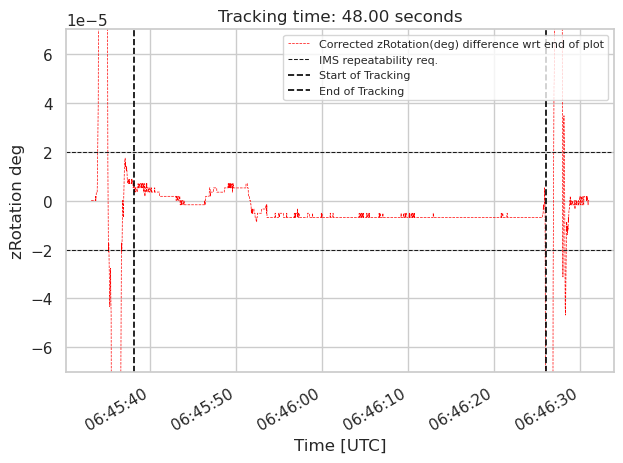

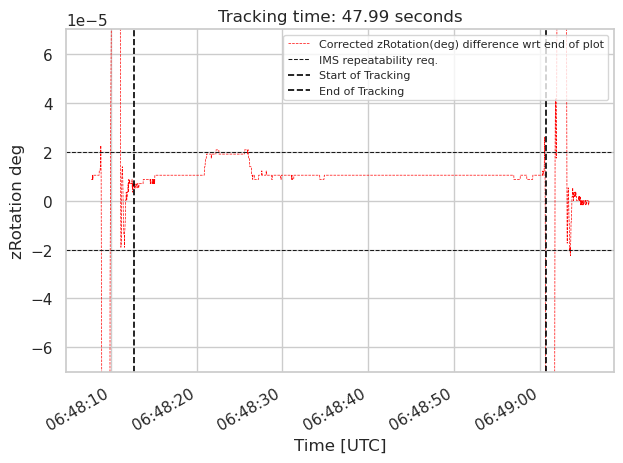

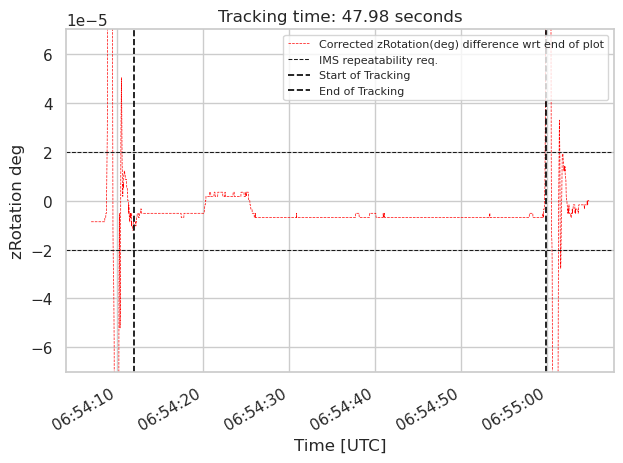

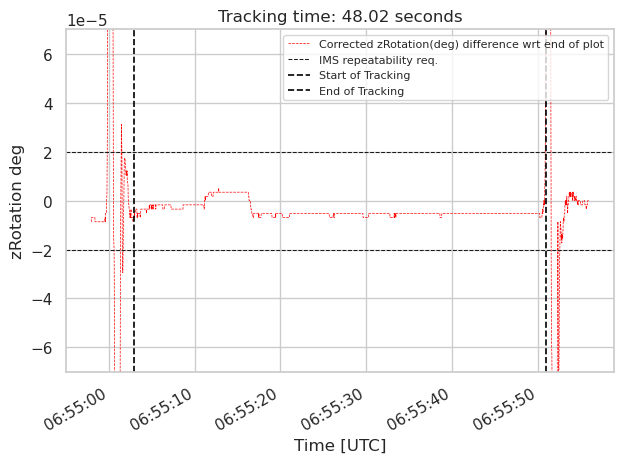

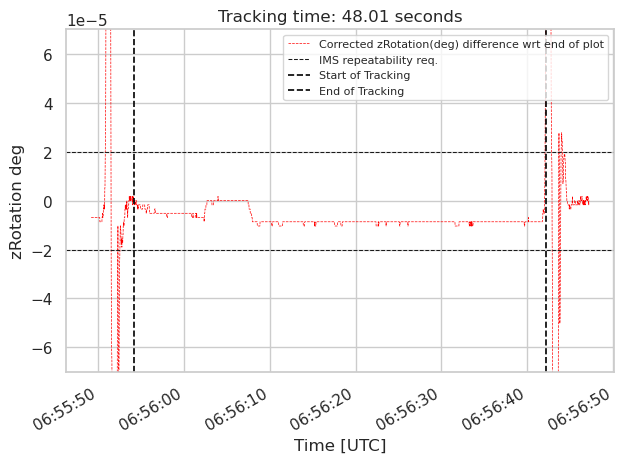

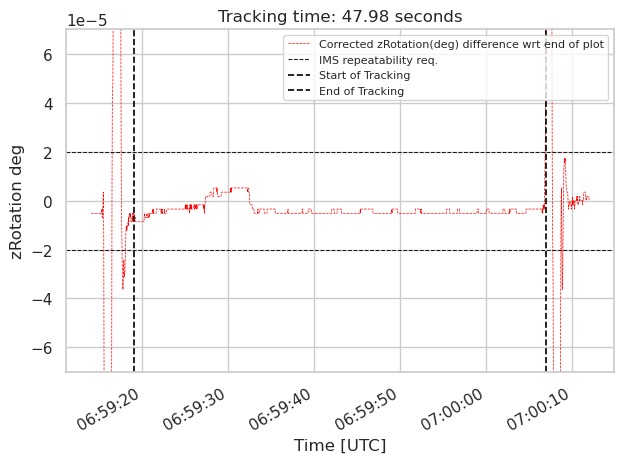

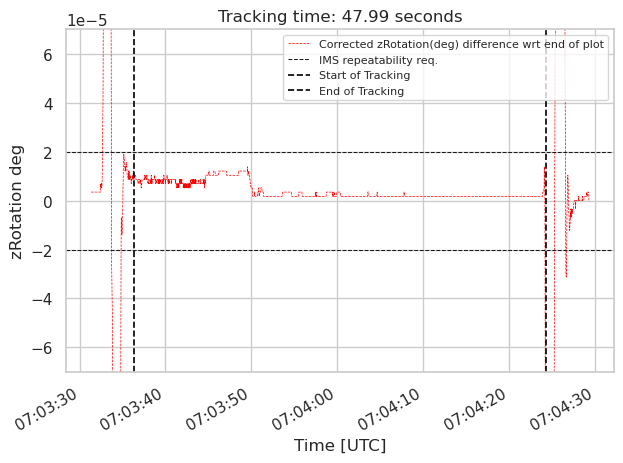

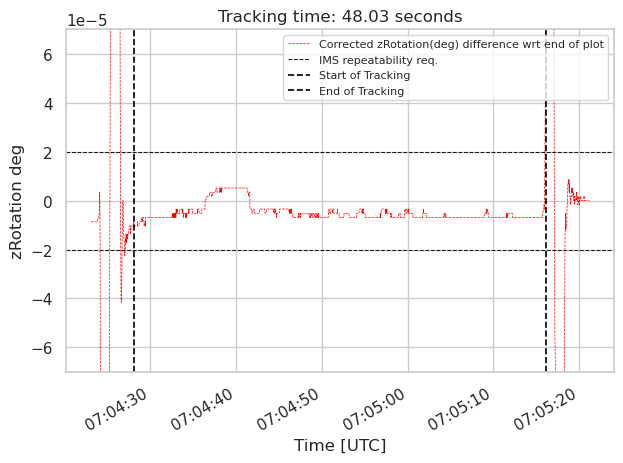

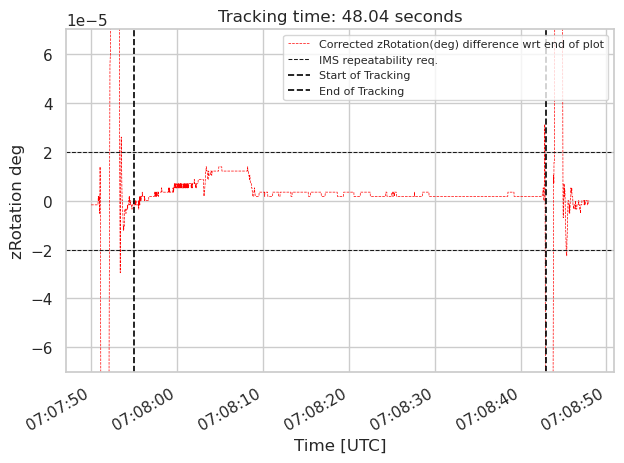

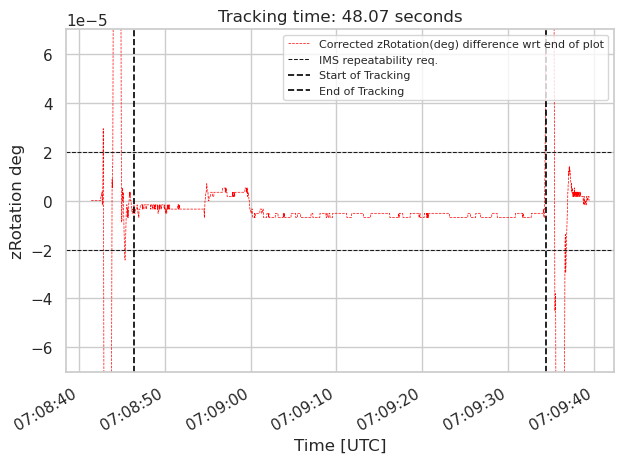

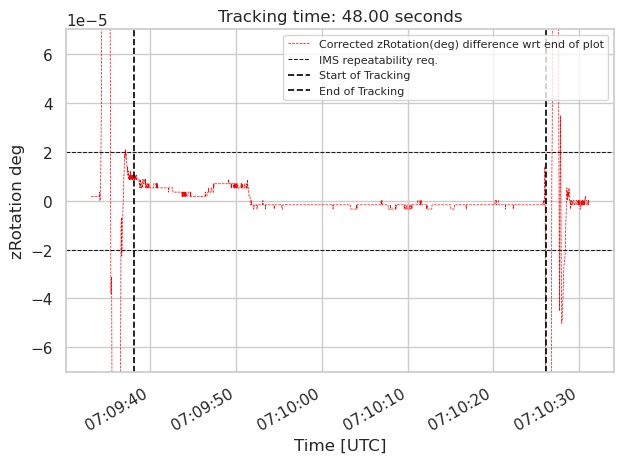

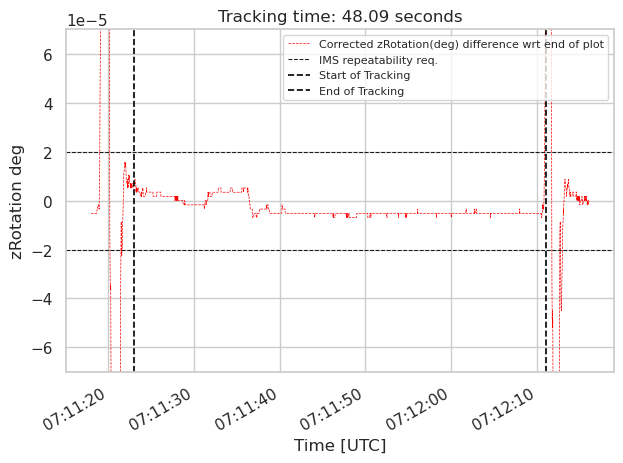

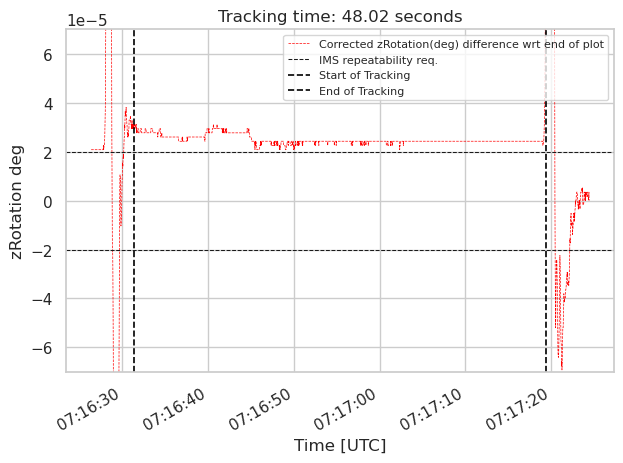

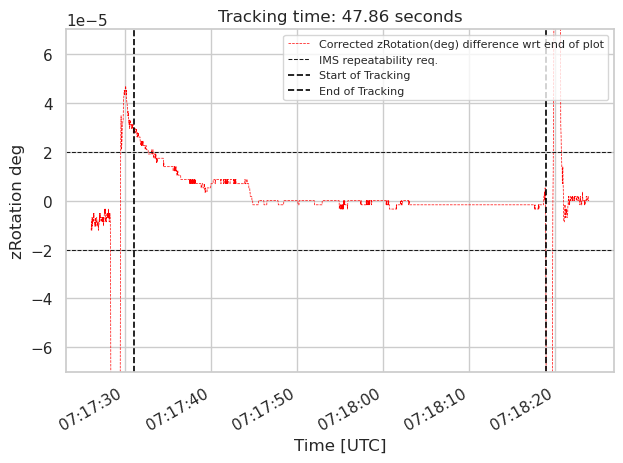

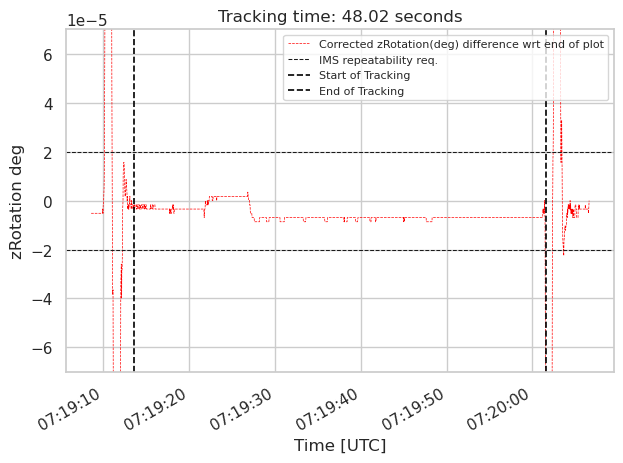

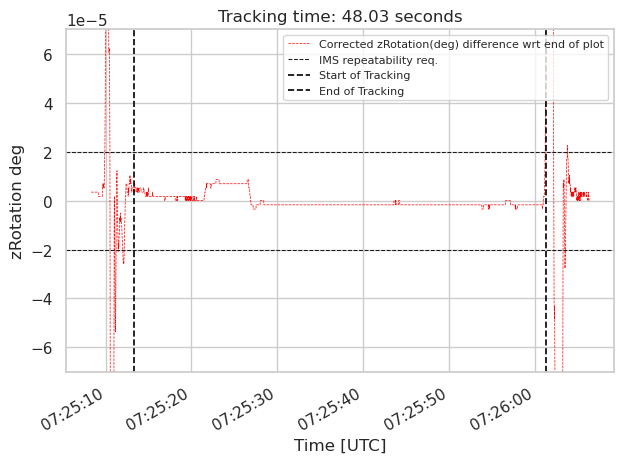

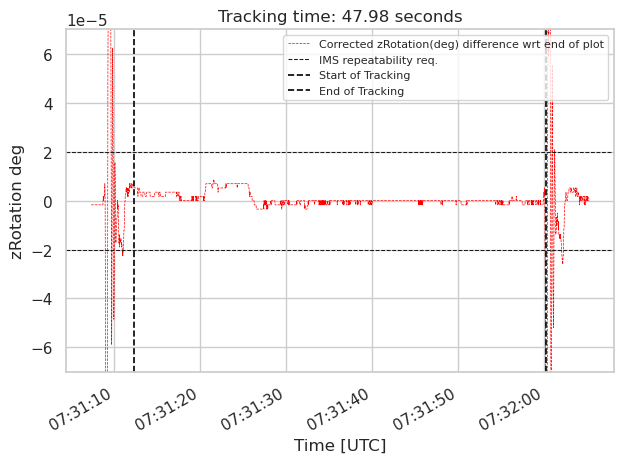

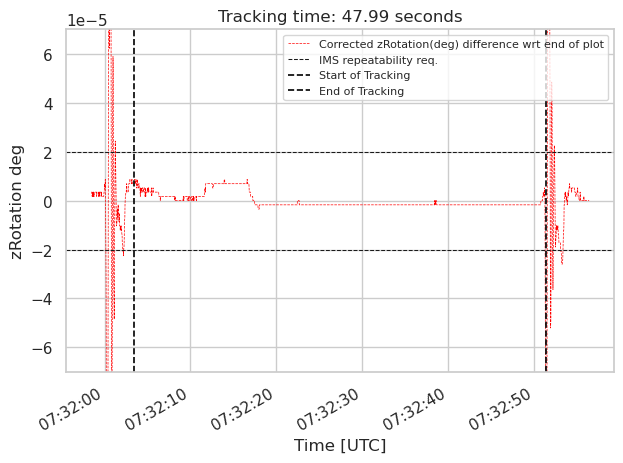

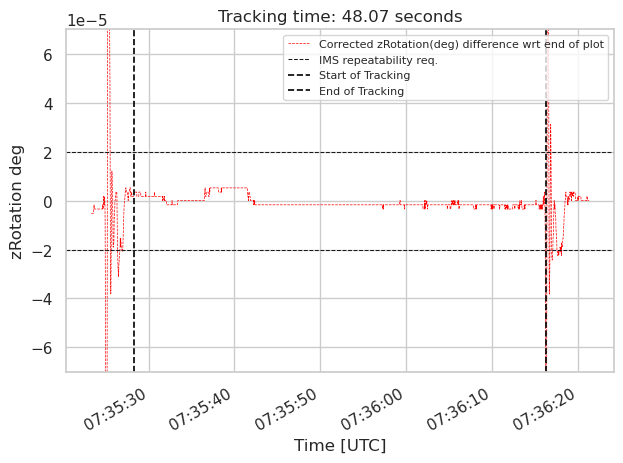

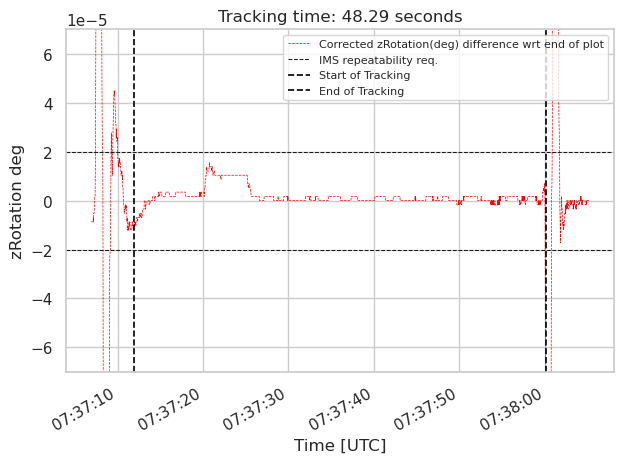

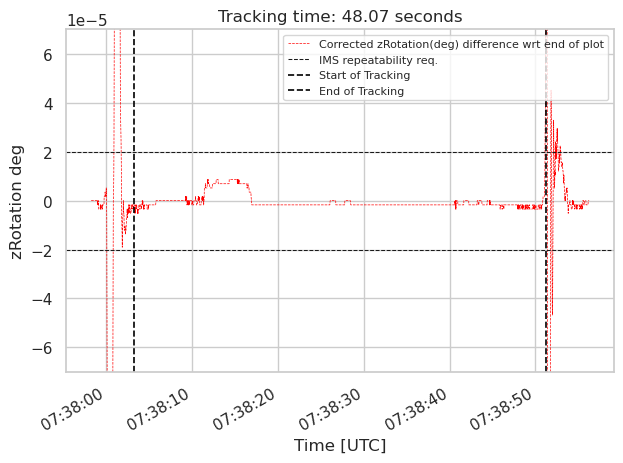

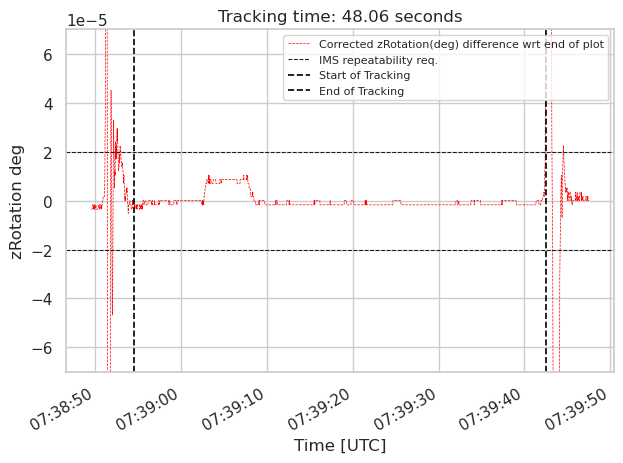

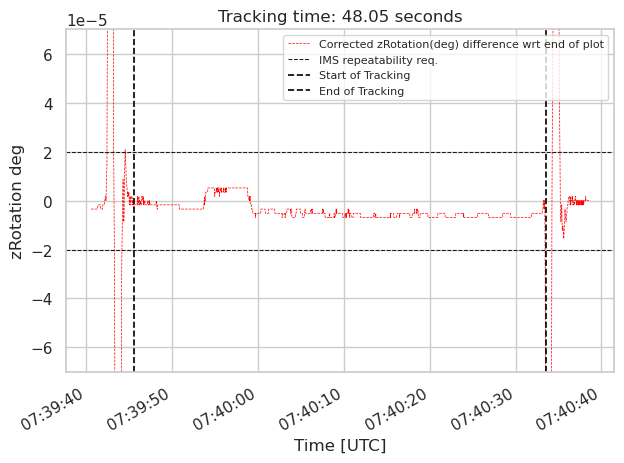

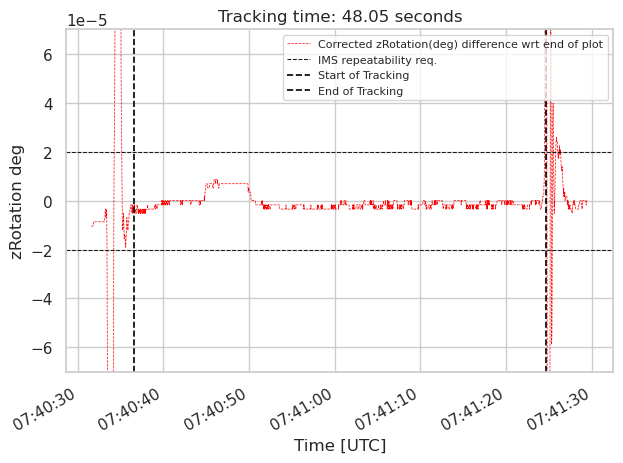

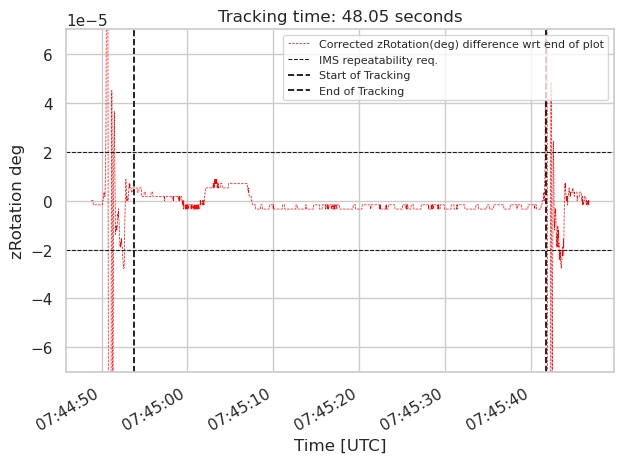

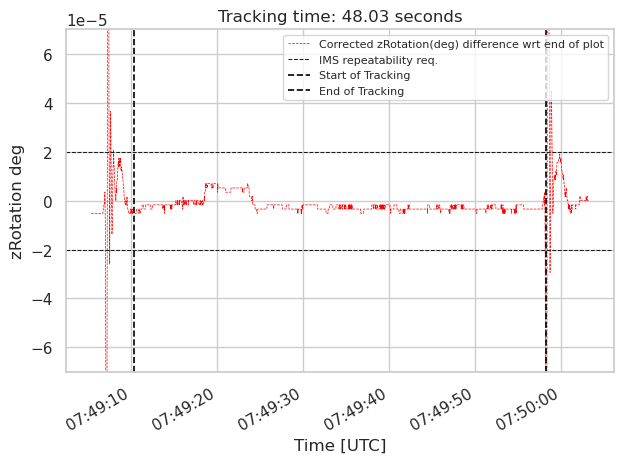

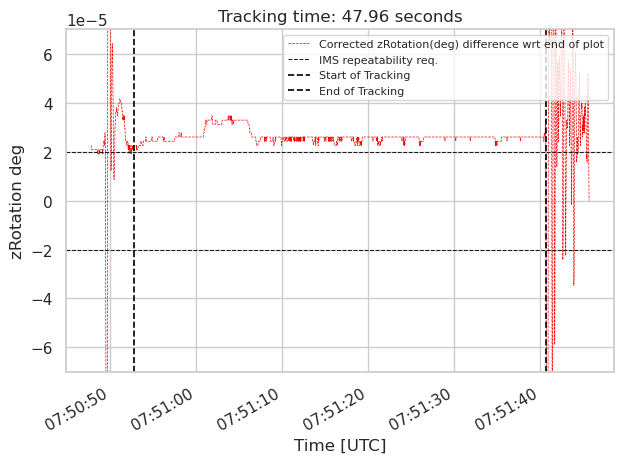

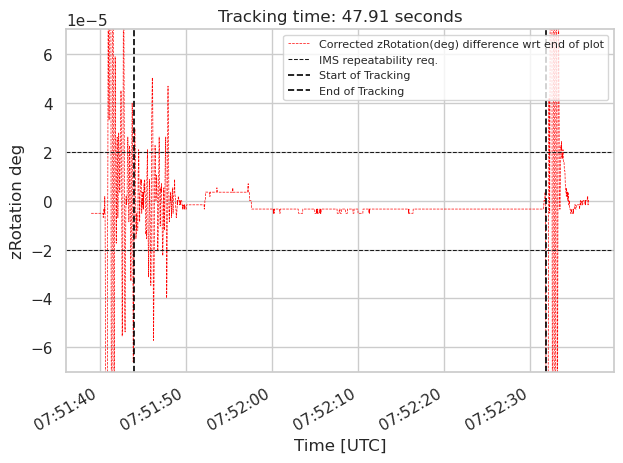

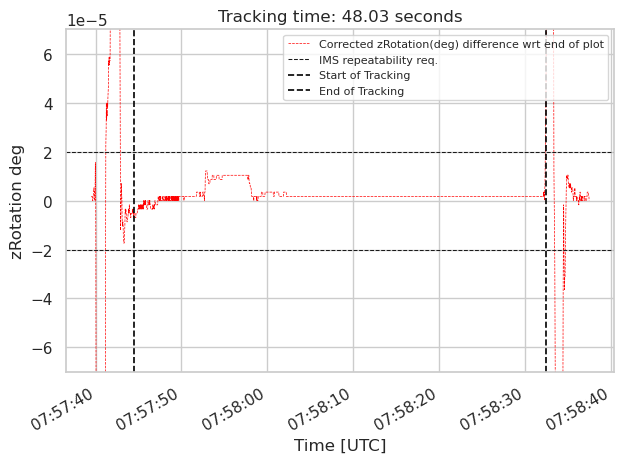

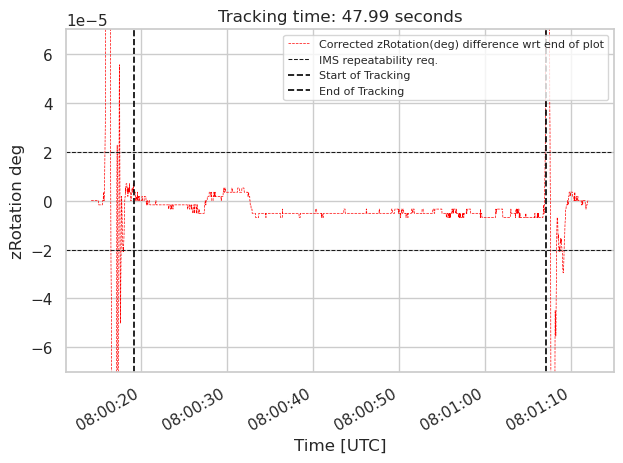

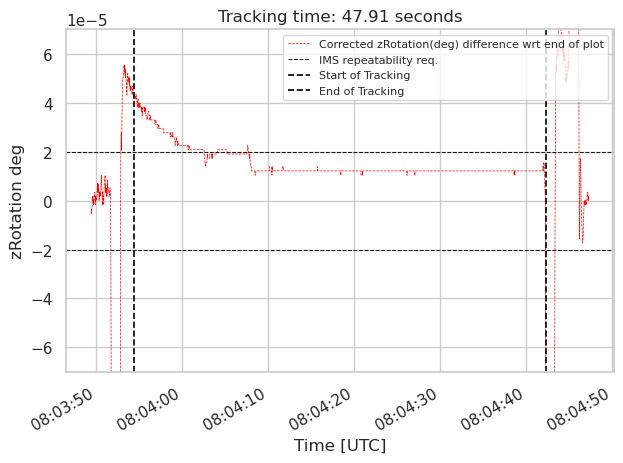

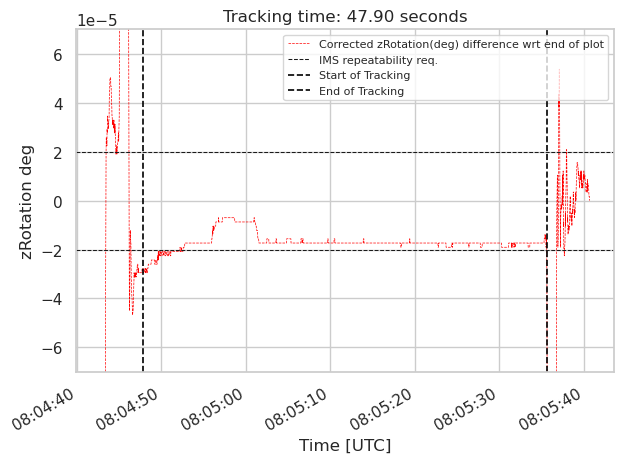

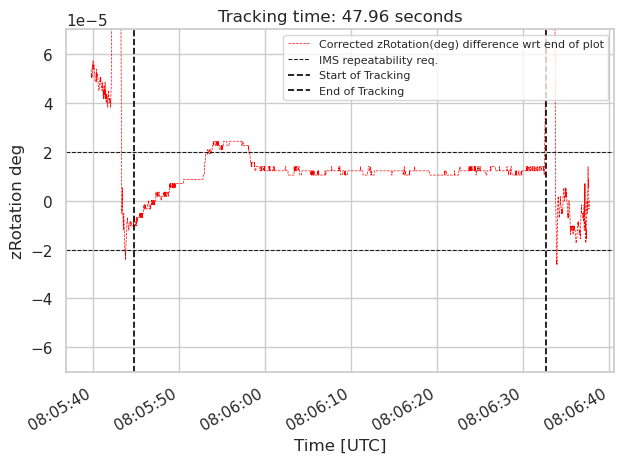

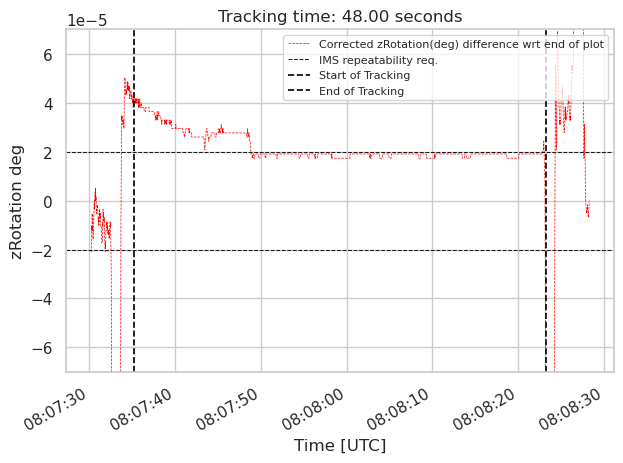

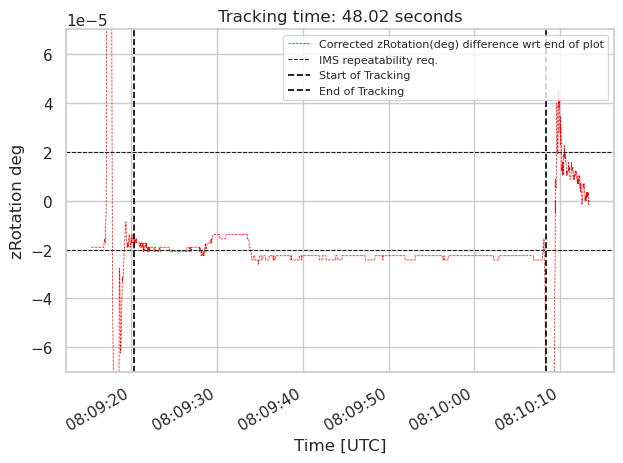

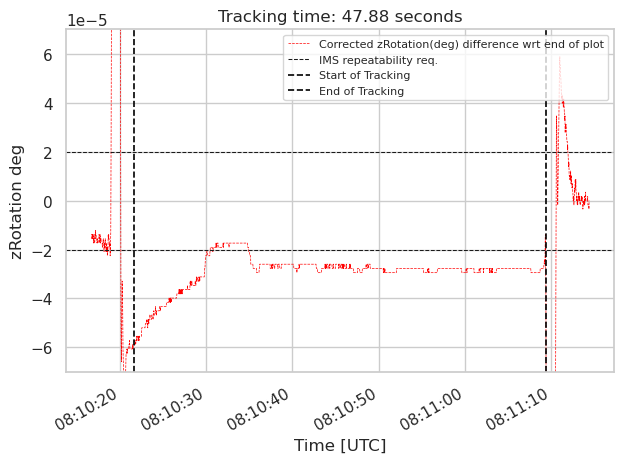

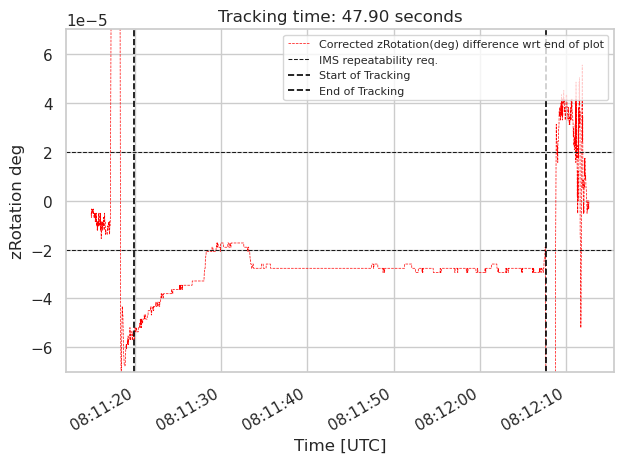

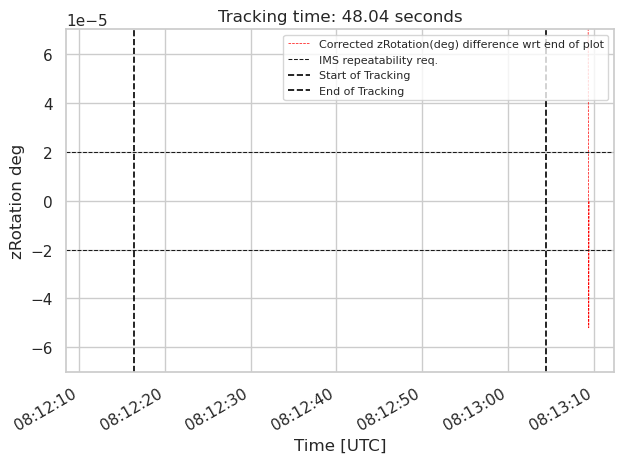

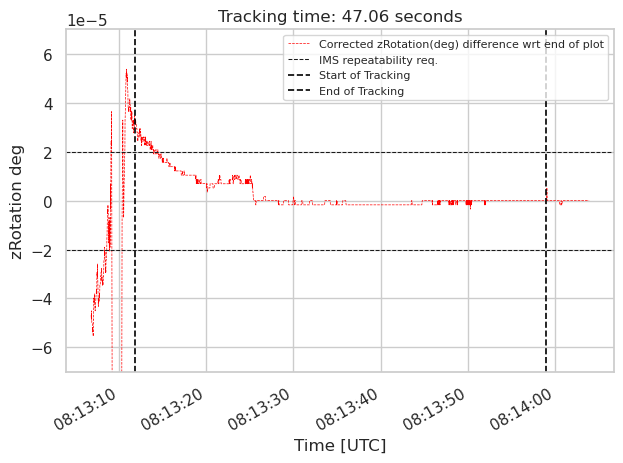

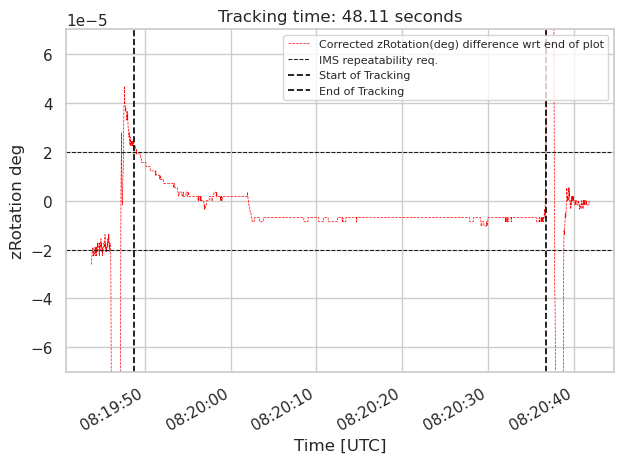

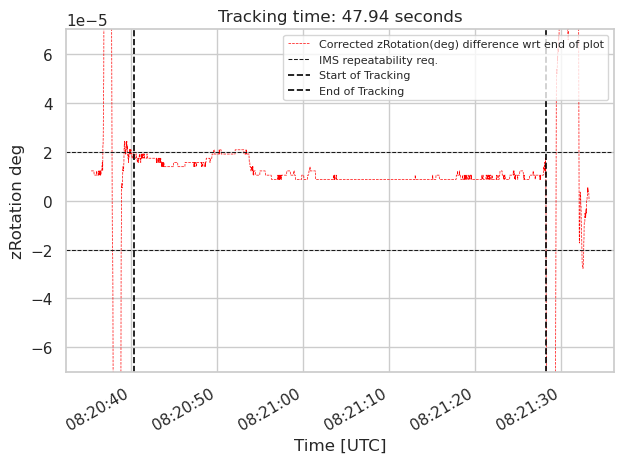

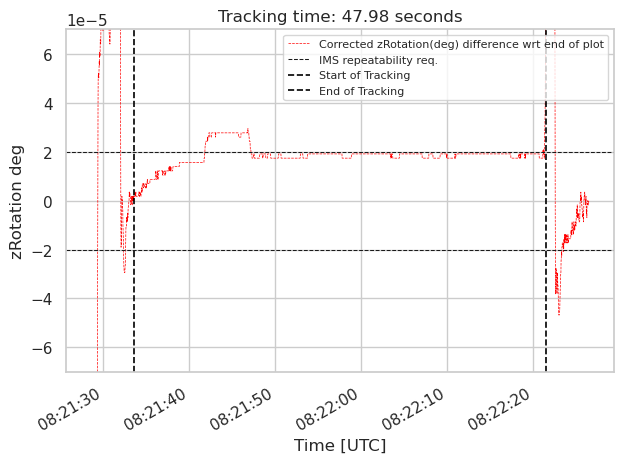

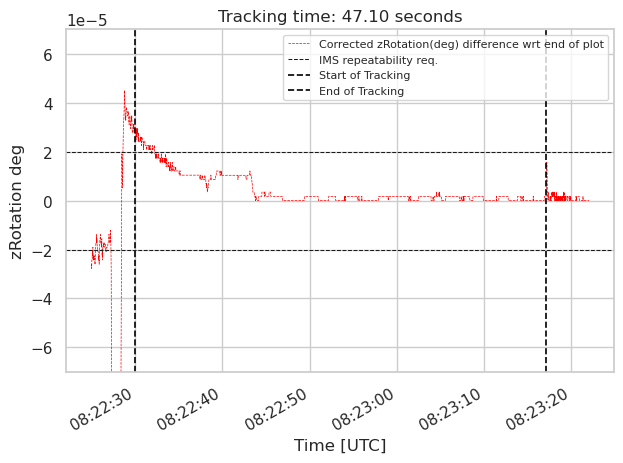

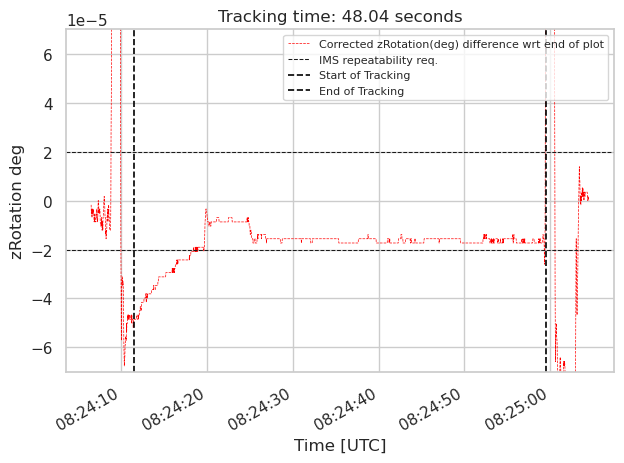

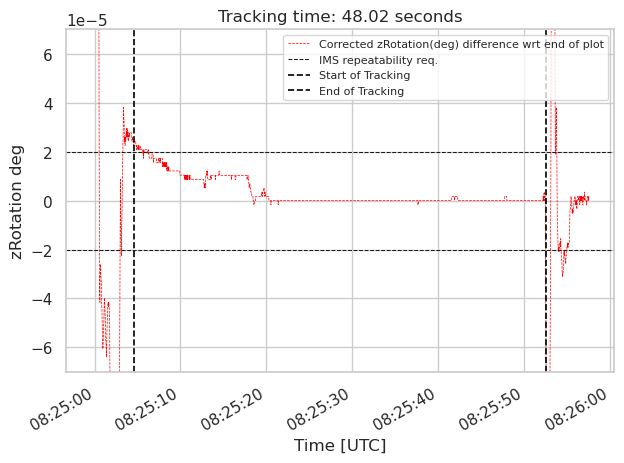

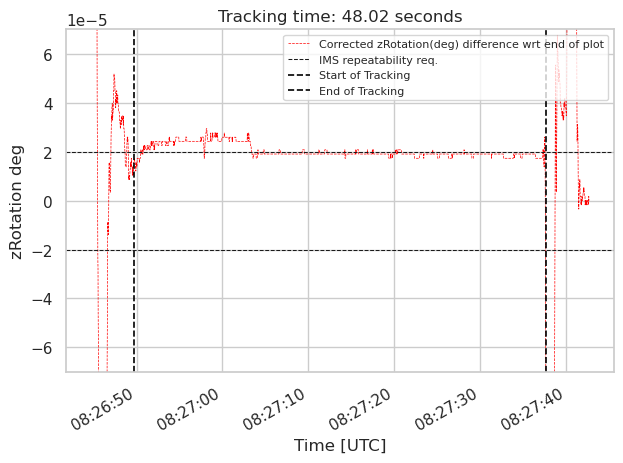

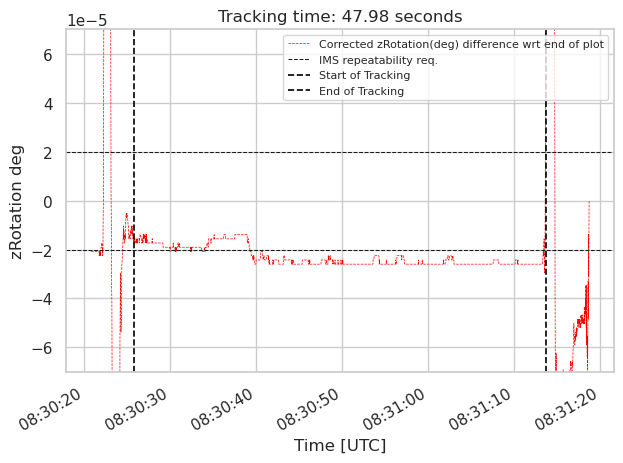

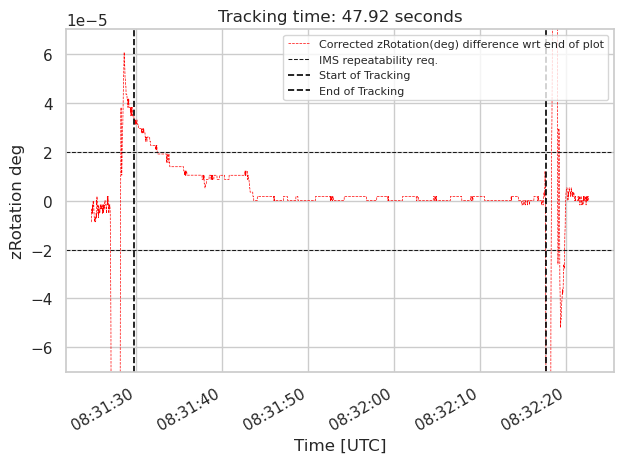

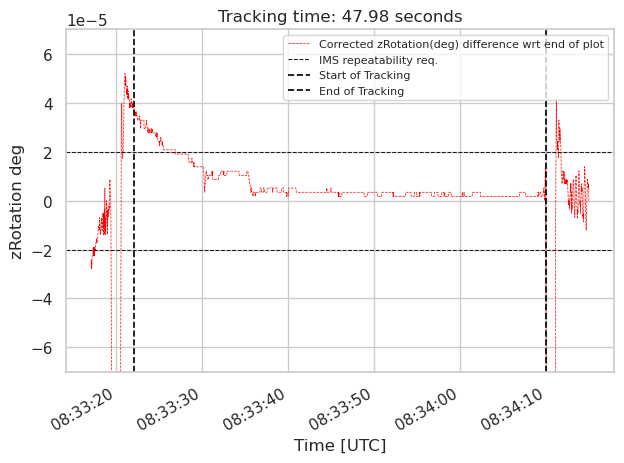

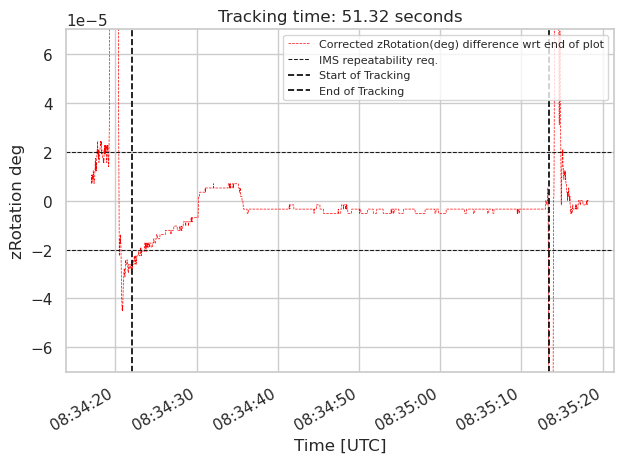

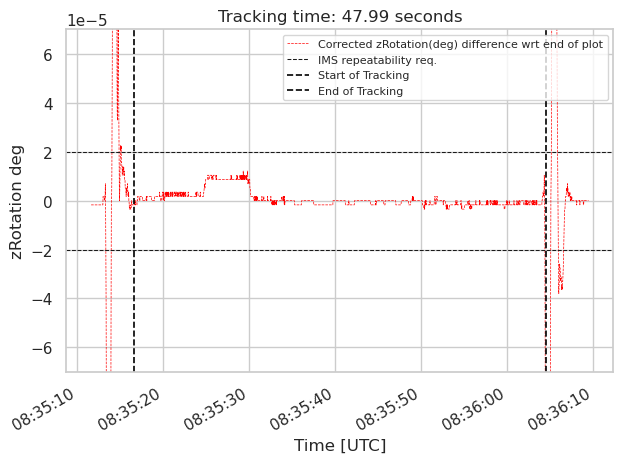

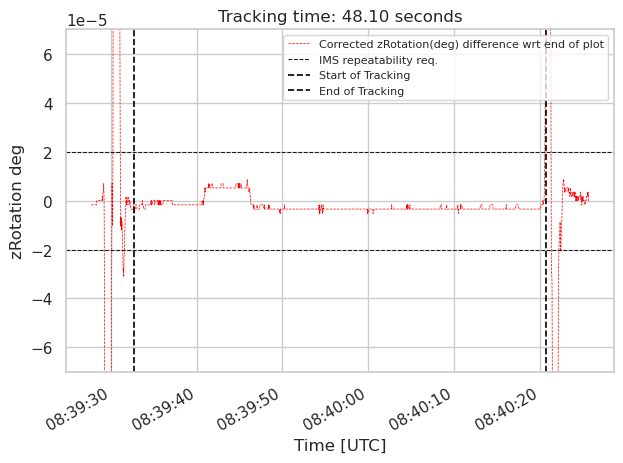

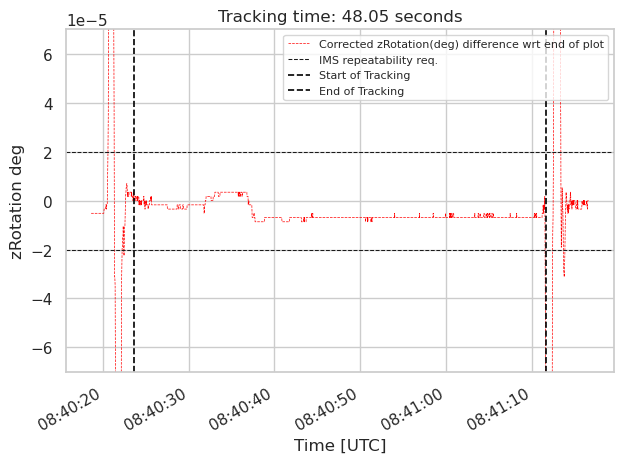

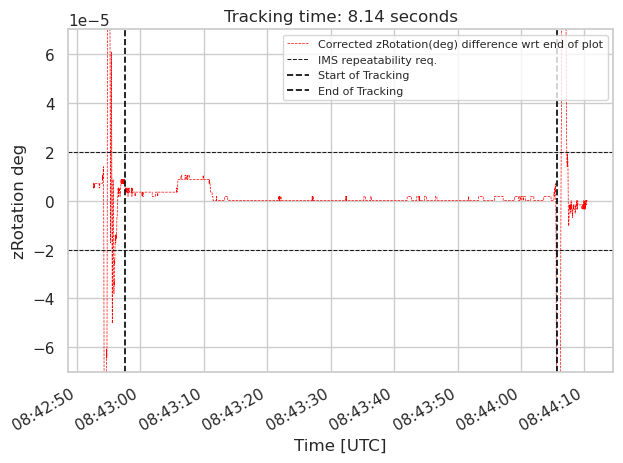

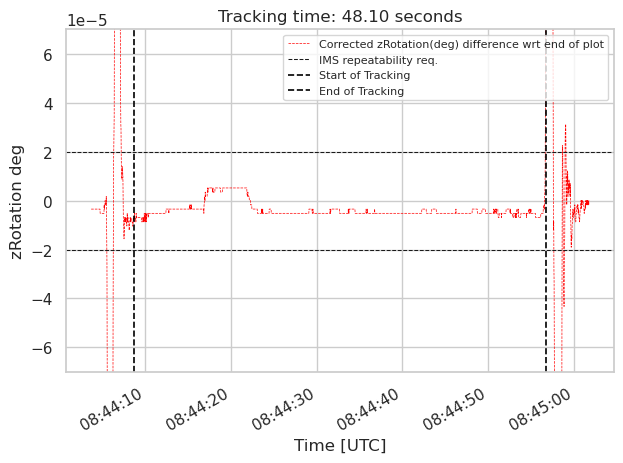

In [150]:
for event in enumerate(tracks_block137):
    targetSeqNum = event[1].seqNum
    for t, tl in enumerate(tracks):
        if tl.seqNum == targetSeqNum:
            print("tracking number: ", t)
            i_track = t

            # Select the information during the tracking
            t0 = Time(tracks[i_track].begin, format="isot", scale="utc")
            t0 = pd.to_datetime(t0.value, utc=True)  # astropy Time to Timestamp conversion
            t1 = Time(tracks[i_track].end, format="isot", scale="utc")
            t1 = pd.to_datetime(t1.value, utc=True)  # astropy Time to Timestamp conversion
            #print("Tracking stop at:", t1)
            
            # Get IMS data
            df_ims = getEfdData(
                     client, "lsst.sal.MTM1M3.imsData", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)
            df_ims = df_ims[all_columns]
            # Convert meter to milimeter
            df_ims[pos_columns] = df_ims[pos_columns] * 1e3
            
            #df_mtmount_ele = getEfdData(
            #client, "lsst.sal.MTMount.elevation", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)

            #df_mtmount_azi = getEfdData(
            #client, "lsst.sal.MTMount.azimuth", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)
            
            #stability throughout a tracking period
            %matplotlib inline
            
            settle_intervals = np.empty(6)
            c = 0.

            for col in all_columns:

                if col in pos_columns:
                   req = req_rms_position
                else:
                   req = req_rms_rotation

            settle_interval = computeSettleTrack(
                 df_ims=df_ims,
                 tt_start=t0,
                 tt_end=t1,        
                 imsColumn=col,
                 rmsReq=req,
                 #req_delta_t=req_delta_t,
                 chi2prob=0.99,
                 delta_t=5
                 )

In [97]:
# Select a event of trancking in block 137
targetSeqNum = 552

In [99]:
# find the appropriate tracking index that has the sequential number selected above
for t, tl in enumerate(tracks): 
    if tl.seqNum == targetSeqNum:
        i_track = t
        break
print(f"Event with seqNum {targetSeqNum} corresponds to track number {i_track}")

Event with seqNum 552 corresponds to track number 223


In [55]:
tracks[i_track]

dayObs: 20240103
seqNum: 1279
type: TRACKING
endReason: SLEWING
duration: 42.13462996482849
begin: <Time object: scale='utc' format='unix' value=1704353983.1915777>
end: <Time object: scale='utc' format='unix' value=1704354025.3262076>
blockInfos: 
    dayObs: 20240103
    seqNum: 255
    blockNumber: 146
    blockId: BL146_O_20240103_000255
    begin: 2024-01-04T07:39:39.231
    end: 2024-01-04T07:40:22.210
    salIndices: [101109]
    tickets: ['SITCOM-885']
    states: 
       RUNNING @ 2024-01-04T07:39:39.231  
       RUNNING @ 2024-01-04T07:40:22.206  
        ENDING @ 2024-01-04T07:40:22.208  
          DONE @ 2024-01-04T07:40:22.210
    dayObs: 20240103
    seqNum: 256
    blockNumber: 146
    blockId: BL146_O_20240103_000256
    begin: 2024-01-04T07:40:24.235
    end: 2024-01-04T07:40:30.601
    salIndices: [101110]
    tickets: ['SITCOM-885']
    states: 
       RUNNING @ 2024-01-04T07:40:24.235  
       RUNNING @ 2024-01-04T07:40:30.533  
       FAILING @ 2024-01-04T07:40:30.

In [56]:
# Select the information during the tracking
t0 = Time(tracks[i_track].begin, format="isot", scale="utc")
t0 = pd.to_datetime(t0.value, utc=True)  # astropy Time to Timestamp conversion
t1 = Time(tracks[i_track].end, format="isot", scale="utc")
t1 = pd.to_datetime(t1.value, utc=True)  # astropy Time to Timestamp conversion
print("Tracking stop at:", t1)

# Get IMS data
df_ims = getEfdData(
    client, "lsst.sal.MTM1M3.imsData", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)
df_ims = df_ims[all_columns]
# Convert meter to milimeter
df_ims[pos_columns] = df_ims[pos_columns] * 1e3

Tracking stop at: 2024-01-04 07:40:25.326000+00:00


In [57]:
df_mtmount_ele = getEfdData(
    client, "lsst.sal.MTMount.elevation", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)

df_mtmount_azi = getEfdData(
    client, "lsst.sal.MTMount.azimuth", event=tracks[i_track], postPadding=delta_t, prePadding=delta_t)

### Look at data

Number of trackings: 370
Mean duration of tracking: 51.943388197228714
Median duration of tracking: 47.981212854385376
Mode of tracking duration (rounded): 48
Standard deviation of tracking duration: 73.04338043176443
Variance of tracking duration: 5335.335424899467
Maximum duration of tracking: 1043.4853157997131
Minimum duration of tracking: 0.3470275402069092


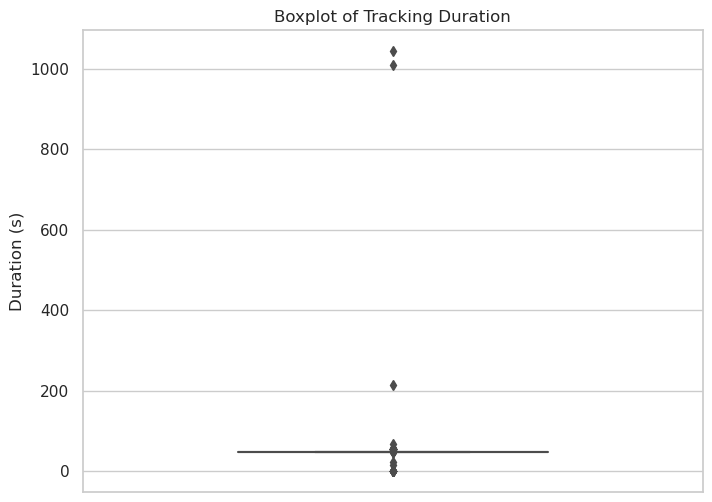

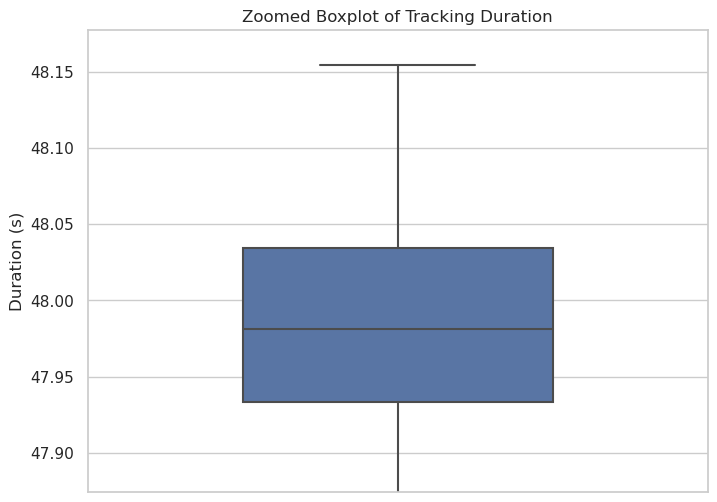

In [58]:
## Time of the tracking:

# Get durations of the tracking
durations = [track.duration for track in tracks_block137]

# Calculate mean, standard deviation, and variance
mean_duration = np.mean(durations)
standard_deviation = np.std(durations)
variance = np.var(durations)
median_duration = np.median(durations)

# Round the durations for mode calculation
rounded_durations = [round(track.duration) for track in tracks_block137]

# Calculate mode of rounded durations
mode_duration = stats.mode(rounded_durations)


# Print the results
print("Number of trackings:", len(durations))
print("Mean duration of tracking:", mean_duration)
print("Median duration of tracking:", median_duration)
print("Mode of tracking duration (rounded):", mode_duration.mode[0])
print("Standard deviation of tracking duration:", standard_deviation)
print("Variance of tracking duration:", variance)
print("Maximum duration of tracking:", np.max(durations))
print("Minimum duration of tracking:", np.min(durations))


# Create a boxplot using seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(y=durations, width=0.5)
plt.title('Boxplot of Tracking Duration')
plt.ylabel('Duration (s)')
plt.show()

# Create a boxplot using seaborn (zoom)
plt.figure(figsize=(8, 6))
sns.boxplot(y=durations, width=0.5)
plt.ylim(np.percentile(durations, 7), np.percentile(durations, 93))
plt.title('Zoomed Boxplot of Tracking Duration')
plt.ylabel('Duration (s)')
plt.show()


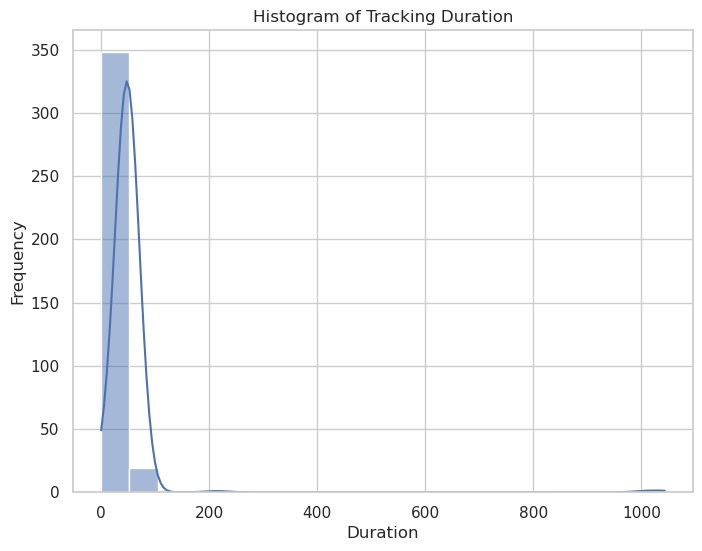

In [59]:
# Create a histogram using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(durations, bins=20, kde=True)
plt.title('Histogram of Tracking Duration')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.show()

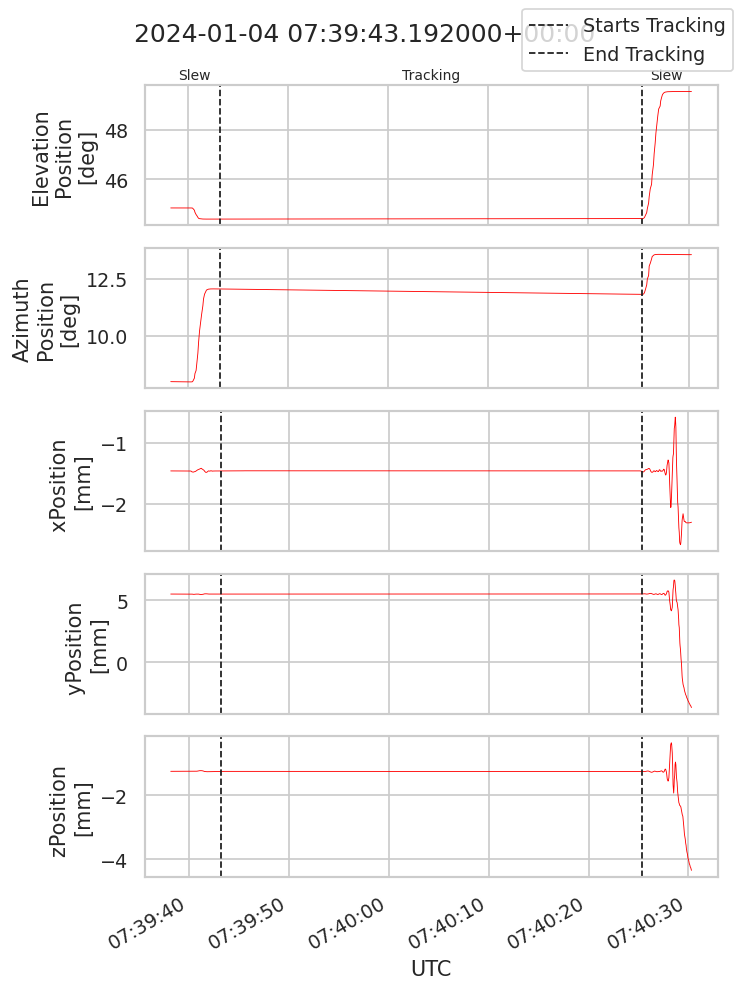

In [60]:
%matplotlib inline
compareIMSMount(
    df_ims,
    df_mtmount_ele,
    df_mtmount_azi,
    t0,
    t1,
    delta_t
)

## Stability tracking period

xPosition
Warning! Telescope movement during tracking exceeds the required rms limits.
yPosition
Warning! Telescope movement during tracking exceeds the required rms limits.
zPosition
Warning! Telescope movement during tracking exceeds the required rms limits.
xRotation
Warning! Telescope movement during tracking exceeds the required rms limits.
yRotation
Warning! Telescope movement during tracking exceeds the required rms limits.
zRotation
Warning! Telescope movement during tracking exceeds the required rms limits.


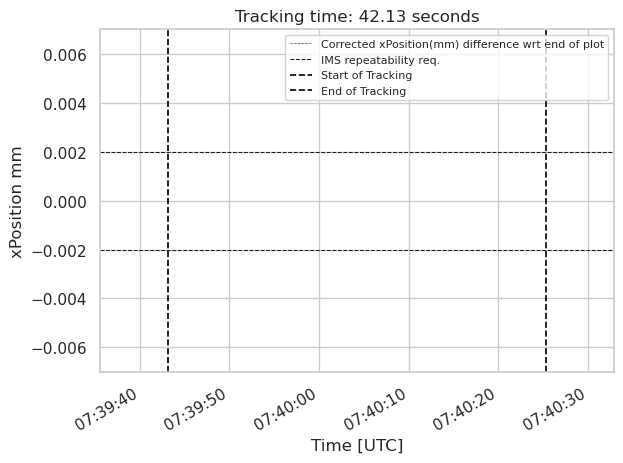

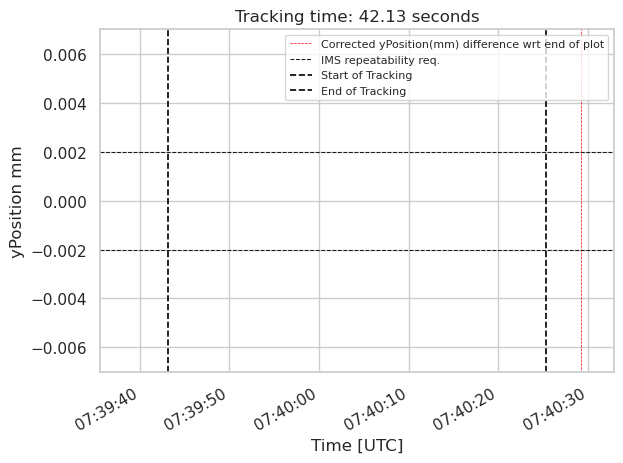

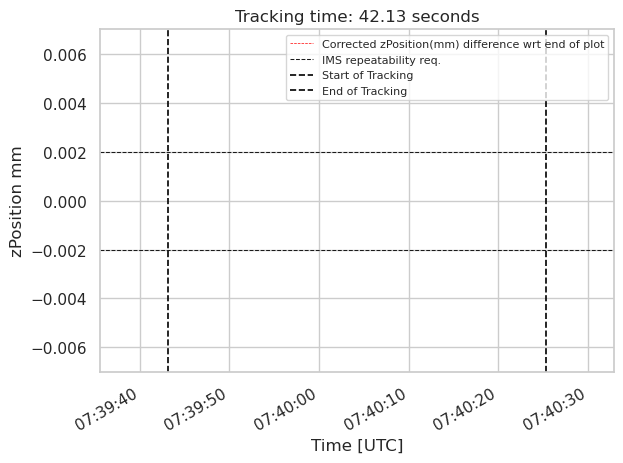

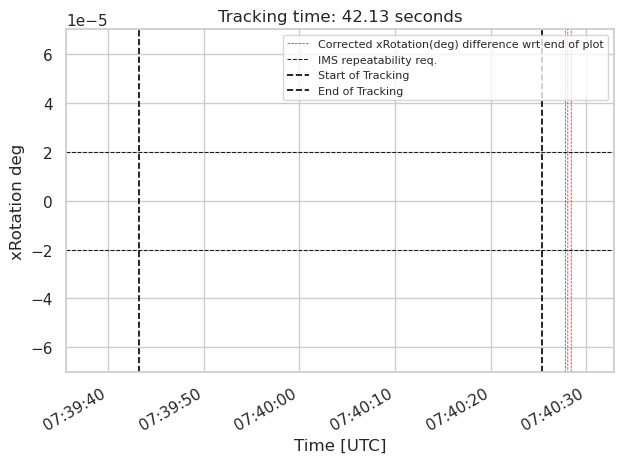

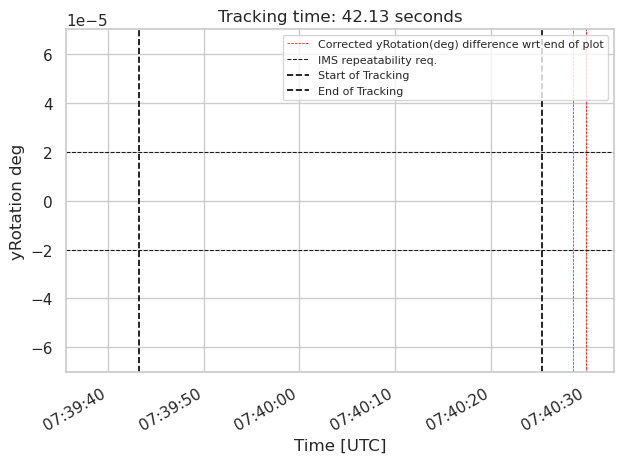

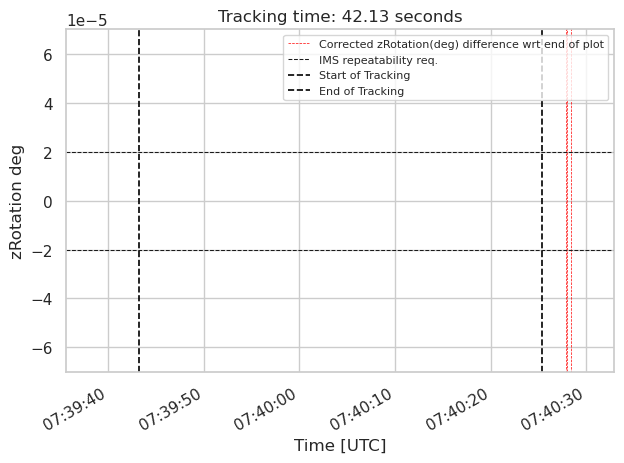

In [63]:
#stability throughout a tracking period
%matplotlib inline

settle_intervals = np.empty(6)
c = 0.

for col in all_columns:
    print(col)
    if col in pos_columns:
        req = req_rms_position
    else:
        req = req_rms_rotation

    settle_interval = computeSettleTrack(
        df_ims=df_ims,
        tt_start=t0,
        tt_end=t1,        
        imsColumn=col,
        rmsReq=req,
        #req_delta_t=req_delta_t,
        chi2prob=0.99,
        delta_t=5
    )